<a href="https://colab.research.google.com/github/AndreiAf02/Transfer_Learning_Fine_Tuning_Update/blob/main/Diabetes_Transductive_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Diabetes Health Indicators - Transductive TL

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C53919):

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)



In [ ]:
data = cdc_diabetes_health_indicators.data
# data (as pandas dataframes)
X = data.features
y = data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [ ]:
X

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,18,0,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,1,28,0,0,0,1,1,0,...,1,0,1,0,0,0,0,2,5,2
253678,1,0,1,23,0,0,0,0,1,1,...,1,0,3,0,0,0,1,7,5,1


In [ ]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [ ]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253676,1.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.75,0.0,0.000000,1.0,0.0,0.833333,0.2,0.428571,1
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [ ]:
y.value_counts()

,count
Diabetes_binary,
0,218334
1,35346


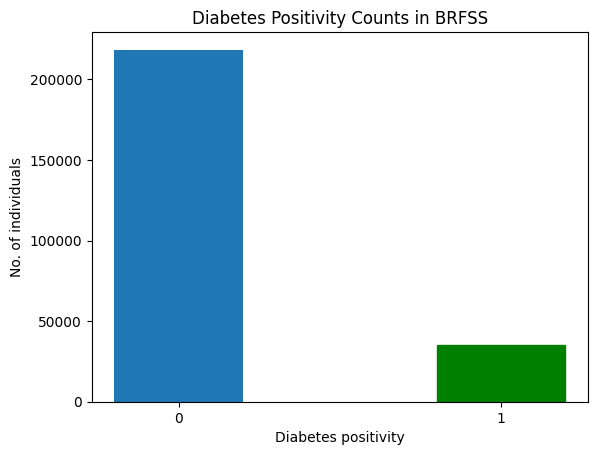

In [ ]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

In [ ]:
X['Education'].value_counts()

,count
Education,
6,107325
5,69910
4,62750
3,9478
2,4043
1,174


In [ ]:
X_scaled[19].value_counts()

,count
19,
1.0,107325
0.8,69910
0.6,62750
0.4,9478
0.2,4043
0.0,174


# Splitting for Source and Target Domains:


# Full Dataset:

In [ ]:
data_S = data2[~data2[19].isin([0.0, 0.2])]  ## Source domain and classification
data_T = data2[data2[19].isin([0.0, 0.2])]  ## Target domain and classification

In [ ]:
data_S

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253674,0.0,0.0,1.0,0.174419,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.166667,1.0,0.571429,0
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [ ]:
data_T

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
21,1.0,1.0,1.0,0.302326,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.00,0.5,1.000000,1.0,0.0,1.000000,0.2,0.285714,0
27,1.0,1.0,1.0,0.186047,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.75,0.0,0.000000,0.0,1.0,0.916667,0.2,0.428571,1
83,0.0,1.0,1.0,0.232558,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,1.0,0.0,1.000000,0.2,0.142857,1
95,1.0,1.0,1.0,0.151163,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.00,0.5,1.000000,1.0,0.0,0.666667,0.2,0.285714,1
190,1.0,0.0,1.0,0.267442,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.75,0.0,0.033333,1.0,1.0,0.666667,0.2,0.571429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253645,1.0,0.0,1.0,0.267442,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.75,0.0,0.000000,0.0,1.0,0.166667,0.2,0.000000,0
253652,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.75,0.0,1.000000,0.0,1.0,0.833333,0.2,0.285714,1
253669,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.00,0.0,0.100000,0.0,1.0,0.416667,0.2,0.428571,0
253672,1.0,0.0,1.0,0.209302,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.916667,0.2,0.000000,0


## Source domain and task labels:

In [ ]:
X_S_full = data_S.iloc[:, :21]
X_S_full       ## Source domain


y_S_full = data_S.iloc[:, 21]
y_S_full       ## Source classification (response)

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0
...,...
253674,0
253675,0
253677,0
253678,0


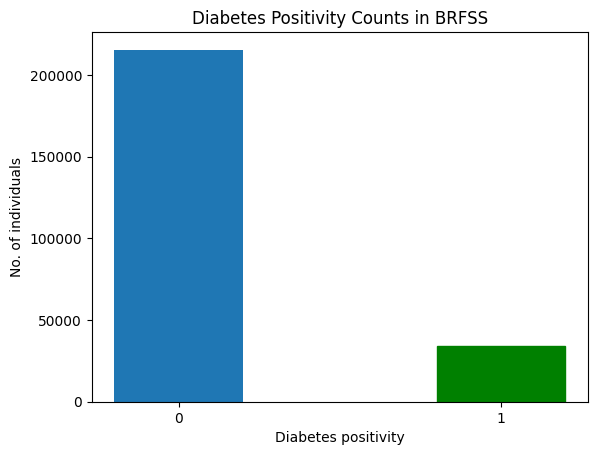

In [ ]:
barlist_S = plt.bar([str(0),str(1)], y_S_full.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

## Target domain and task labels:

In [ ]:
X_T_full = data_T.iloc[:, :21]
X_T_full       ## Target domain


y_T_full = data_T.iloc[:, 21]
y_T_full       ## Target classification (response)

,Diabetes_binary
21,0
27,1
83,1
95,1
190,0
...,...
253645,0
253652,1
253669,0
253672,0


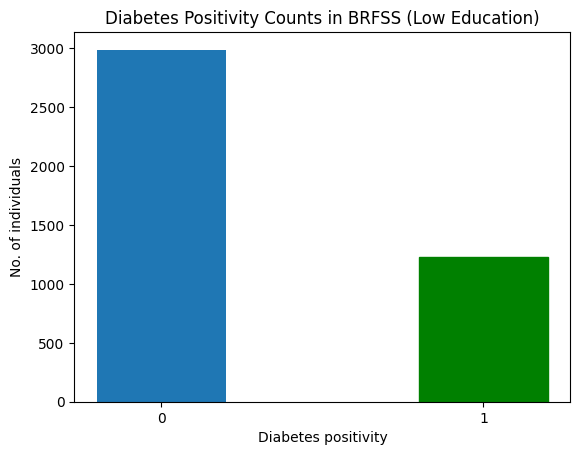

In [ ]:
barlist_T = plt.bar([str(0),str(1)], y_T_full.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Low Education)")
plt.show()

## DNN & Transductive TL Algorithms:

In [ ]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)
    return time_elapsed


In [ ]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)

    return fpr, tnr, fnr, tpr, time_elapsed

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (199570, 21)
y_S_train: (199570,)
X_S_test: (49893, 21)
y_S_test: (49893,)


In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
times = 20

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)
    model_source = create_dnn_model(X_S_train.shape[1])
    result_imbalanced = train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    Training_time.append(result_imbalanced)
    FPR.append(result_TL_imbalanced[0])
    TPR.append(result_TL_imbalanced[1])
    FNR.append(result_TL_imbalanced[2])
    TNR.append(result_TL_imbalanced[3])
    TL_time.append(result_TL_imbalanced[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7894 - loss: 0.3326 - val_AUC: 0.8201 - val_loss: 0.3128
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8230 - loss: 0.3120 - val_AUC: 0.8224 - val_loss: 0.3191
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8225 - loss: 0.3119 - val_AUC: 0.8249 - val_loss: 0.3112
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8261 - loss: 0.3092 - val_AUC: 0.8249 - val_loss: 0.3111
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8269 - loss: 0.3131 - val_AUC: 0.8260 - val_loss: 0.3095
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8276 - loss: 0.3097 - val_AUC: 0.8256 - val_loss: 0.3096
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8301 - loss: 0.3080 - val_AUC: 0.8259 - val_loss: 0.3093
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8316 - loss: 0.3075 - val_AUC: 0.8266 - val_loss: 0.3088
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7608676895272468
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      2987
           1       0.65      0.17      0.27      1230

    accuracy                           0.73      4217
   macro avg       0.69      0.56      0.55      4217
weighted avg       0.71      0.73      0.67      4217

FPR 0.03783059926347506 TPR: 0.9621694007365249 FNR: 0.832520325203252 TNR: 0.16747967479674797
Best threshold based on F1-score: 0.23725078999996185
False Negative Rate: 0.832520325203252
Time elapsed (performance): 0.4921484159999636
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.7873 - loss: 0.3304 - val_AUC: 0.8208 - val_loss: 0.3125
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8235 - loss: 0.3122 - val_AUC: 0.8233 - val_loss: 0.3105
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8233 - loss: 0.3111 - val_AUC: 0.8246 - val_loss: 0.3102
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8277 - loss: 0.3079 - val_AUC: 0.8252 - val_loss: 0.3103
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8275 - loss: 0.3088 - val_AUC: 0.8250 - val_loss: 0.3233
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8275 - loss: 0.3098 - val_AUC: 0.8253 - val_loss: 0.3166
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8295 - loss: 0.3104 - val_AUC: 0.8259 - val_loss: 0.3117
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8297 - loss: 0.3089 - val_AUC: 0.8258 - val_loss: 0.3101
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7779 - loss: 0.3379 - val_AUC: 0.8216 - val_loss: 0.3125
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8216 - loss: 0.3137 - val_AUC: 0.8213 - val_loss: 0.3132
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8257 - loss: 0.3084 - val_AUC: 0.8229 - val_loss: 0.3143
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8273 - loss: 0.3094 - val_AUC: 0.8250 - val_loss: 0.3092
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8293 - loss: 0.3076 - val_AUC: 0.8252 - val_loss: 0.3167
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8276 - loss: 0.3074 - val_AUC: 0.8253 - val_loss: 0.3100
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8282 - loss: 0.3098 - val_AUC: 0.8264 - val_loss: 0.3089
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8300 - loss: 0.3098 - val_AUC: 0.8265 - val_loss: 0.3091
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7661 - loss: 0.3457 - val_AUC: 0.8210 - val_loss: 0.3126
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8224 - loss: 0.3118 - val_AUC: 0.8248 - val_loss: 0.3106
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8239 - loss: 0.3124 - val_AUC: 0.8240 - val_loss: 0.3105
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8262 - loss: 0.3111 - val_AUC: 0.8250 - val_loss: 0.3100
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8261 - loss: 0.3101 - val_AUC: 0.8258 - val_loss: 0.3091
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8258 - loss: 0.3082 - val_AUC: 0.8257 - val_loss: 0.3104
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8306 - loss: 0.3060 - val_AUC: 0.8254 - val_loss: 0.3104
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8285 - loss: 0.3078 - val_AUC: 0.8261 - val_loss: 0.3092
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7579655471814176
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      2987
           1       0.61      0.25      0.35      1230

    accuracy                           0.73      4217
   macro avg       0.68      0.59      0.59      4217
weighted avg       0.71      0.73      0.69      4217

FPR 0.06595246066287244 TPR: 0.9340475393371276 FNR: 0.751219512195122 TNR: 0.24878048780487805
Best threshold based on F1-score: 0.22407841682434082
False Negative Rate: 0.751219512195122
Time elapsed (performance): 0.39892566799971974
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7850 - loss: 0.3341 - val_AUC: 0.8210 - val_loss: 0.3128
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8239 - loss: 0.3122 - val_AUC: 0.8217 - val_loss: 0.3122
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8256 - loss: 0.3114 - val_AUC: 0.8250 - val_loss: 0.3101
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8270 - loss: 0.3096 - val_AUC: 0.8252 - val_loss: 0.3096
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8286 - loss: 0.3094 - val_AUC: 0.8251 - val_loss: 0.3100
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8259 - loss: 0.3100 - val_AUC: 0.8266 - val_loss: 0.3091
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8282 - loss: 0.3084 - val_AUC: 0.8264 - val_loss: 0.3089
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8288 - loss: 0.3076 - val_AUC: 0.8265 - val_loss: 0.3087
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7859 - loss: 0.3341 - val_AUC: 0.8201 - val_loss: 0.3129
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8230 - loss: 0.3134 - val_AUC: 0.8209 - val_loss: 0.3131
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8255 - loss: 0.3103 - val_AUC: 0.8237 - val_loss: 0.3125
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8266 - loss: 0.3088 - val_AUC: 0.8244 - val_loss: 0.3128
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8254 - loss: 0.3103 - val_AUC: 0.8248 - val_loss: 0.3106
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8274 - loss: 0.3093 - val_AUC: 0.8249 - val_loss: 0.3098
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8283 - loss: 0.3076 - val_AUC: 0.8253 - val_loss: 0.3128
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8298 - loss: 0.3073 - val_AUC: 0.8258 - val_loss: 0.3092
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.7763 - loss: 0.3407 - val_AUC: 0.8192 - val_loss: 0.3154
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8224 - loss: 0.3141 - val_AUC: 0.8233 - val_loss: 0.3182
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8244 - loss: 0.3111 - val_AUC: 0.8249 - val_loss: 0.3114
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8253 - loss: 0.3108 - val_AUC: 0.8262 - val_loss: 0.3088
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8276 - loss: 0.3089 - val_AUC: 0.8269 - val_loss: 0.3086
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8295 - loss: 0.3079 - val_AUC: 0.8266 - val_loss: 0.3099
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8283 - loss: 0.3082 - val_AUC: 0.8261 - val_loss: 0.3098
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8299 - loss: 0.3078 - val_AUC: 0.8261 - val_loss: 0.3095
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7789 - loss: 0.3342 - val_AUC: 0.8212 - val_loss: 0.3121
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - AUC: 0.8223 - loss: 0.3130 - val_AUC: 0.8236 - val_loss: 0.3141
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8238 - loss: 0.3120 - val_AUC: 0.8247 - val_loss: 0.3119
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8289 - loss: 0.3095 - val_AUC: 0.8246 - val_loss: 0.3099
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8250 - loss: 0.3109 - val_AUC: 0.8259 - val_loss: 0.3090
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8311 - loss: 0.3069 - val_AUC: 0.8256 - val_loss: 0.3109
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8279 - loss: 0.3084 - val_AUC: 0.8258 - val_loss: 0.3094
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8323 - loss: 0.3067 - val_AUC: 0.8245 - val_loss: 0.3109
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.760137833048903
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      2987
           1       0.61      0.19      0.29      1230

    accuracy                           0.73      4217
   macro avg       0.68      0.57      0.56      4217
weighted avg       0.70      0.73      0.68      4217

FPR 0.05021760964178105 TPR: 0.949782390358219 FNR: 0.8073170731707318 TNR: 0.19268292682926824
Best threshold based on F1-score: 0.23748977482318878
False Negative Rate: 0.8073170731707318
Time elapsed (performance): 0.4444935779993102
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7908 - loss: 0.3300 - val_AUC: 0.8206 - val_loss: 0.3127
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8226 - loss: 0.3122 - val_AUC: 0.8238 - val_loss: 0.3115
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8258 - loss: 0.3114 - val_AUC: 0.8249 - val_loss: 0.3113
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8284 - loss: 0.3108 - val_AUC: 0.8256 - val_loss: 0.3103
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8274 - loss: 0.3114 - val_AUC: 0.8265 - val_loss: 0.3092
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8301 - loss: 0.3068 - val_AUC: 0.8264 - val_loss: 0.3106
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8302 - loss: 0.3067 - val_AUC: 0.8259 - val_loss: 0.3101
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8304 - loss: 0.3091 - val_AUC: 0.8207 - val_loss: 0.3127
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7873 - loss: 0.3325 - val_AUC: 0.8215 - val_loss: 0.3120
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8210 - loss: 0.3130 - val_AUC: 0.8210 - val_loss: 0.3133
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8232 - loss: 0.3108 - val_AUC: 0.8247 - val_loss: 0.3120
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8274 - loss: 0.3111 - val_AUC: 0.8240 - val_loss: 0.3116
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8284 - loss: 0.3095 - val_AUC: 0.8259 - val_loss: 0.3124
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8263 - loss: 0.3085 - val_AUC: 0.8258 - val_loss: 0.3093
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8273 - loss: 0.3111 - val_AUC: 0.8220 - val_loss: 0.3135
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8305 - loss: 0.3085 - val_AUC: 0.8264 - val_loss: 0.3089
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7773 - loss: 0.3372 - val_AUC: 0.8215 - val_loss: 0.3125
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8216 - loss: 0.3123 - val_AUC: 0.8230 - val_loss: 0.3108
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8240 - loss: 0.3110 - val_AUC: 0.8228 - val_loss: 0.3109
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8272 - loss: 0.3093 - val_AUC: 0.8247 - val_loss: 0.3098
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8271 - loss: 0.3094 - val_AUC: 0.8258 - val_loss: 0.3090
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8251 - loss: 0.3090 - val_AUC: 0.8264 - val_loss: 0.3087
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8300 - loss: 0.3076 - val_AUC: 0.8254 - val_loss: 0.3105
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8276 - loss: 0.3114 - val_AUC: 0.8256 - val_loss: 0.3095
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7621913114008945
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.84      2987
           1       0.67      0.13      0.22      1230

    accuracy                           0.73      4217
   macro avg       0.70      0.55      0.53      4217
weighted avg       0.71      0.73      0.66      4217

FPR 0.027452293270840308 TPR: 0.9725477067291597 FNR: 0.865040650406504 TNR: 0.13495934959349598
Best threshold based on F1-score: 0.26508253812789917
False Negative Rate: 0.865040650406504
Time elapsed (performance): 0.41393764700023894
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7840 - loss: 0.3331 - val_AUC: 0.8185 - val_loss: 0.3141
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8209 - loss: 0.3135 - val_AUC: 0.8222 - val_loss: 0.3112
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8240 - loss: 0.3121 - val_AUC: 0.8260 - val_loss: 0.3091
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8270 - loss: 0.3116 - val_AUC: 0.8258 - val_loss: 0.3096
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8270 - loss: 0.3096 - val_AUC: 0.8255 - val_loss: 0.3114
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8271 - loss: 0.3091 - val_AUC: 0.8260 - val_loss: 0.3097
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8301 - loss: 0.3073 - val_AUC: 0.8266 - val_loss: 0.3088
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8268 - loss: 0.3094 - val_AUC: 0.8263 - val_loss: 0.3144
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7885 - loss: 0.3343 - val_AUC: 0.8197 - val_loss: 0.3203
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8217 - loss: 0.3148 - val_AUC: 0.8207 - val_loss: 0.3146
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8244 - loss: 0.3120 - val_AUC: 0.8236 - val_loss: 0.3104
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8264 - loss: 0.3109 - val_AUC: 0.8249 - val_loss: 0.3113
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8277 - loss: 0.3097 - val_AUC: 0.8264 - val_loss: 0.3138
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8284 - loss: 0.3090 - val_AUC: 0.8257 - val_loss: 0.3102
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8286 - loss: 0.3102 - val_AUC: 0.8257 - val_loss: 0.3097
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8305 - loss: 0.3085 - val_AUC: 0.8259 - val_loss: 0.3095
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.7836 - loss: 0.3336 - val_AUC: 0.8217 - val_loss: 0.3120
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.8222 - loss: 0.3133 - val_AUC: 0.8219 - val_loss: 0.3134
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8249 - loss: 0.3122 - val_AUC: 0.8250 - val_loss: 0.3098
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8259 - loss: 0.3100 - val_AUC: 0.8253 - val_loss: 0.3094
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8286 - loss: 0.3074 - val_AUC: 0.8249 - val_loss: 0.3133
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8293 - loss: 0.3078 - val_AUC: 0.8238 - val_loss: 0.3135
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8269 - loss: 0.3088 - val_AUC: 0.8246 - val_loss: 0.3098
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8292 - loss: 0.3088 - val_AUC: 0.8256 - val_loss: 0.3091
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7856 - loss: 0.3353 - val_AUC: 0.8212 - val_loss: 0.3119
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8207 - loss: 0.3156 - val_AUC: 0.8218 - val_loss: 0.3172
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8252 - loss: 0.3113 - val_AUC: 0.8253 - val_loss: 0.3097
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8255 - loss: 0.3112 - val_AUC: 0.8250 - val_loss: 0.3132
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8264 - loss: 0.3112 - val_AUC: 0.8253 - val_loss: 0.3125
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8280 - loss: 0.3087 - val_AUC: 0.8262 - val_loss: 0.3093
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8262 - loss: 0.3097 - val_AUC: 0.8247 - val_loss: 0.3096
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8305 - loss: 0.3095 - val_AUC: 0.8251 - val_loss: 0.3095
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7776 - loss: 0.3430 - val_AUC: 0.8219 - val_loss: 0.3124
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8212 - loss: 0.3139 - val_AUC: 0.8239 - val_loss: 0.3107
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8262 - loss: 0.3098 - val_AUC: 0.8250 - val_loss: 0.3114
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8244 - loss: 0.3110 - val_AUC: 0.8252 - val_loss: 0.3098
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8278 - loss: 0.3093 - val_AUC: 0.8263 - val_loss: 0.3090
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8304 - loss: 0.3090 - val_AUC: 0.8256 - val_loss: 0.3094
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8305 - loss: 0.3061 - val_AUC: 0.8259 - val_loss: 0.3090
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8303 - loss: 0.3086 - val_AUC: 0.8259 - val_loss: 0.3109
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7815 - loss: 0.3353 - val_AUC: 0.8202 - val_loss: 0.3126
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8211 - loss: 0.3150 - val_AUC: 0.8242 - val_loss: 0.3106
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8267 - loss: 0.3108 - val_AUC: 0.8245 - val_loss: 0.3102
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8262 - loss: 0.3094 - val_AUC: 0.8243 - val_loss: 0.3109
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8267 - loss: 0.3108 - val_AUC: 0.8264 - val_loss: 0.3089
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8277 - loss: 0.3088 - val_AUC: 0.8260 - val_loss: 0.3089
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8272 - loss: 0.3112 - val_AUC: 0.8269 - val_loss: 0.3103
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8305 - loss: 0.3072 - val_AUC: 0.8264 - val_loss: 0.3085
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7867 - loss: 0.3332 - val_AUC: 0.8221 - val_loss: 0.3148
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8224 - loss: 0.3138 - val_AUC: 0.8230 - val_loss: 0.3126
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8248 - loss: 0.3105 - val_AUC: 0.8248 - val_loss: 0.3099
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8262 - loss: 0.3095 - val_AUC: 0.8257 - val_loss: 0.3107
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8295 - loss: 0.3076 - val_AUC: 0.8236 - val_loss: 0.3129
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8295 - loss: 0.3099 - val_AUC: 0.8261 - val_loss: 0.3115
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8287 - loss: 0.3098 - val_AUC: 0.8260 - val_loss: 0.3092
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8281 - loss: 0.3098 - val_AUC: 0.8254 - val_loss: 0.3096
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7853 - loss: 0.3326 - val_AUC: 0.8218 - val_loss: 0.3124
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8245 - loss: 0.3115 - val_AUC: 0.8226 - val_loss: 0.3112
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8243 - loss: 0.3100 - val_AUC: 0.8247 - val_loss: 0.3099
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8288 - loss: 0.3103 - val_AUC: 0.8268 - val_loss: 0.3097
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8296 - loss: 0.3069 - val_AUC: 0.8244 - val_loss: 0.3111
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8300 - loss: 0.3071 - val_AUC: 0.8267 - val_loss: 0.3091
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8298 - loss: 0.3084 - val_AUC: 0.8268 - val_loss: 0.3090
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8314 - loss: 0.3058 - val_AUC: 0.8250 - val_loss: 0.3163
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7570071937746495
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      2987
           1       0.60      0.21      0.31      1230

    accuracy                           0.73      4217
   macro avg       0.67      0.58      0.57      4217
weighted avg       0.70      0.73      0.68      4217

FPR 0.0555741546702377 TPR: 0.9444258453297623 FNR: 0.7934959349593496 TNR: 0.20650406504065044
Best threshold based on F1-score: 0.2465474009513855
False Negative Rate: 0.7934959349593496
Time elapsed (performance): 0.4001853640002082
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.7883 - loss: 0.3328 - val_AUC: 0.8191 - val_loss: 0.3137
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8243 - loss: 0.3106 - val_AUC: 0.8238 - val_loss: 0.3110
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8265 - loss: 0.3098 - val_AUC: 0.8241 - val_loss: 0.3125
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8274 - loss: 0.3116 - val_AUC: 0.8247 - val_loss: 0.3096
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8274 - loss: 0.3101 - val_AUC: 0.8255 - val_loss: 0.3118
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8289 - loss: 0.3086 - val_AUC: 0.8252 - val_loss: 0.3143
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8294 - loss: 0.3090 - val_AUC: 0.8256 - val_loss: 0.3099
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8292 - loss: 0.3085 - val_AUC: 0.8250 - val_loss: 0.3103
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('Imbalanced.csv')

    Source time       FPR       TPR       FNR       TNR  Target time
0    169.823434  0.037831  0.962169  0.832520  0.167480     0.492148
1    172.240320  0.066622  0.933378  0.744715  0.255285     0.306363
2    173.524201  0.036157  0.963843  0.856911  0.143089     0.363327
3    169.851805  0.065952  0.934048  0.751220  0.248780     0.398926
4    155.006351  0.050552  0.949448  0.791057  0.208943     0.410545
5    172.338158  0.074322  0.925678  0.730894  0.269106     0.778163
6    165.223163  0.046535  0.953465  0.820325  0.179675     0.406718
7    152.648413  0.050218  0.949782  0.807317  0.192683     0.444494
8    178.712067  0.070639  0.929361  0.736585  0.263415     0.339133
9    152.223393  0.047205  0.952795  0.797561  0.202439     0.767075
10   182.324512  0.027452  0.972548  0.865041  0.134959     0.413938
11   180.057278  0.054235  0.945765  0.780488  0.219512     0.408777
12   148.329698  0.042183  0.957817  0.823577  0.176423     0.324219
13   162.679543  0.071309  0.92869

# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
times = 30

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=False)
    data_S_SRS_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRS = data_S_SRS_RUS.iloc[:, :21]
    y_S_SRS = data_S_SRS_RUS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
    model_SRS = create_dnn_model(X_S_train.shape[1])
    result_SRS = train_and_evaluate(model_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS = Transductive_TL(model_SRS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS)
    FPR.append(result_TL_SRS[0])
    TPR.append(result_TL_SRS[1])
    FNR.append(result_TL_SRS[2])
    TNR.append(result_TL_SRS[3])
    TL_time.append(result_TL_SRS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7844 - loss: 0.5557 - val_AUC: 0.8181 - val_loss: 0.5195
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8145 - loss: 0.5196 - val_AUC: 0.8224 - val_loss: 0.5169
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8242 - loss: 0.5088 - val_AUC: 0.8243 - val_loss: 0.5129
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8235 - loss: 0.5082 - val_AUC: 0.8267 - val_loss: 0.5086
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8223 - loss: 0.5108 - val_AUC: 0.8265 - val_loss: 0.5111
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8240 - loss: 0.5088 - val_AUC: 0.8268 - val_loss: 0.5144
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8262 - loss: 0.5059 - val_AUC: 0.8259 - val_loss: 0.5092
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8272 - loss: 0.5048 - val_AUC: 0.8278 - val_loss: 0.5077
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7832 - loss: 0.5596 - val_AUC: 0.8147 - val_loss: 0.5266
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8192 - loss: 0.5162 - val_AUC: 0.8211 - val_loss: 0.5142
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8196 - loss: 0.5141 - val_AUC: 0.8226 - val_loss: 0.5129
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8286 - loss: 0.5046 - val_AUC: 0.8253 - val_loss: 0.5095
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8177 - loss: 0.5161 - val_AUC: 0.8252 - val_loss: 0.5104
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8220 - loss: 0.5110 - val_AUC: 0.8232 - val_loss: 0.5120
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8251 - loss: 0.5082 - val_AUC: 0.8265 - val_loss: 0.5081
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8290 - loss: 0.5030 - val_AUC: 0.8253 - val_loss: 0.5112
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


AUC-ROC: 0.7591442320516275
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.40      0.55      2987
           1       0.39      0.92      0.54      1230

    accuracy                           0.55      4217
   macro avg       0.65      0.66      0.55      4217
weighted avg       0.77      0.55      0.55      4217

FPR 0.6046200200870439 TPR: 0.9195121951219513 FNR: 0.08048780487804878 TNR: 0.39537997991295615
Best threshold based on F1-score: 0.6967868804931641
False Negative Rate: 0.08048780487804878
Time elapsed (performance): 0.3688793229999874
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7711 - loss: 0.5694 - val_AUC: 0.8151 - val_loss: 0.5254
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8178 - loss: 0.5165 - val_AUC: 0.8185 - val_loss: 0.5181
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8225 - loss: 0.5109 - val_AUC: 0.8202 - val_loss: 0.5187
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8240 - loss: 0.5086 - val_AUC: 0.8218 - val_loss: 0.5155
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8263 - loss: 0.5062 - val_AUC: 0.8225 - val_loss: 0.5159
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8258 - loss: 0.5057 - val_AUC: 0.8218 - val_loss: 0.5127
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8259 - loss: 0.5061 - val_AUC: 0.8213 - val_loss: 0.5135
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8266 - loss: 0.5050 - val_AUC: 0.8220 - val_loss: 0.5138
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7902 - loss: 0.5517 - val_AUC: 0.8157 - val_loss: 0.5248
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8206 - loss: 0.5126 - val_AUC: 0.8223 - val_loss: 0.5148
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8246 - loss: 0.5087 - val_AUC: 0.8240 - val_loss: 0.5149
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8250 - loss: 0.5062 - val_AUC: 0.8246 - val_loss: 0.5112
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8249 - loss: 0.5087 - val_AUC: 0.8254 - val_loss: 0.5117
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8218 - loss: 0.5113 - val_AUC: 0.8256 - val_loss: 0.5104
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8288 - loss: 0.5030 - val_AUC: 0.8258 - val_loss: 0.5116
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8252 - loss: 0.5080 - val_AUC: 0.8259 - val_loss: 0.5139
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7684 - loss: 0.5692 - val_AUC: 0.8167 - val_loss: 0.5250
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8166 - loss: 0.5193 - val_AUC: 0.8227 - val_loss: 0.5119
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8251 - loss: 0.5076 - val_AUC: 0.8246 - val_loss: 0.5124
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8280 - loss: 0.5041 - val_AUC: 0.8262 - val_loss: 0.5099
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8256 - loss: 0.5064 - val_AUC: 0.8270 - val_loss: 0.5069
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8267 - loss: 0.5066 - val_AUC: 0.8272 - val_loss: 0.5076
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8269 - loss: 0.5054 - val_AUC: 0.8276 - val_loss: 0.5064
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8274 - loss: 0.5047 - val_AUC: 0.8277 - val_loss: 0.5061
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7834 - loss: 0.5576 - val_AUC: 0.8212 - val_loss: 0.5181
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8203 - loss: 0.5136 - val_AUC: 0.8269 - val_loss: 0.5110
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8256 - loss: 0.5076 - val_AUC: 0.8264 - val_loss: 0.5091
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8256 - loss: 0.5074 - val_AUC: 0.8285 - val_loss: 0.5054
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8271 - loss: 0.5051 - val_AUC: 0.8304 - val_loss: 0.5035
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8264 - loss: 0.5056 - val_AUC: 0.8298 - val_loss: 0.5046
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8263 - loss: 0.5057 - val_AUC: 0.8294 - val_loss: 0.5047
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8286 - loss: 0.5030 - val_AUC: 0.8314 - val_loss: 0.5027
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7869 - loss: 0.5550 - val_AUC: 0.8135 - val_loss: 0.5266
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8188 - loss: 0.5158 - val_AUC: 0.8203 - val_loss: 0.5146
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8224 - loss: 0.5099 - val_AUC: 0.8208 - val_loss: 0.5134
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8300 - loss: 0.5022 - val_AUC: 0.8215 - val_loss: 0.5147
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8260 - loss: 0.5071 - val_AUC: 0.8217 - val_loss: 0.5130
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8286 - loss: 0.5039 - val_AUC: 0.8225 - val_loss: 0.5221
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8269 - loss: 0.5063 - val_AUC: 0.8231 - val_loss: 0.5252
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8321 - loss: 0.5000 - val_AUC: 0.8226 - val_loss: 0.5140
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7804 - loss: 0.5624 - val_AUC: 0.8204 - val_loss: 0.5152
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8153 - loss: 0.5188 - val_AUC: 0.8244 - val_loss: 0.5103
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8182 - loss: 0.5155 - val_AUC: 0.8272 - val_loss: 0.5102
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8224 - loss: 0.5107 - val_AUC: 0.8270 - val_loss: 0.5068
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8253 - loss: 0.5079 - val_AUC: 0.8287 - val_loss: 0.5064
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8244 - loss: 0.5081 - val_AUC: 0.8285 - val_loss: 0.5068
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8251 - loss: 0.5076 - val_AUC: 0.8294 - val_loss: 0.5048
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8267 - loss: 0.5060 - val_AUC: 0.8290 - val_loss: 0.5045
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7885 - loss: 0.5542 - val_AUC: 0.8200 - val_loss: 0.5165
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8168 - loss: 0.5179 - val_AUC: 0.8255 - val_loss: 0.5094
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8204 - loss: 0.5132 - val_AUC: 0.8263 - val_loss: 0.5188
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8223 - loss: 0.5104 - val_AUC: 0.8259 - val_loss: 0.5177
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8236 - loss: 0.5095 - val_AUC: 0.8287 - val_loss: 0.5073
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8262 - loss: 0.5062 - val_AUC: 0.8278 - val_loss: 0.5063
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5054 - val_AUC: 0.8283 - val_loss: 0.5067
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8286 - loss: 0.5026 - val_AUC: 0.8276 - val_loss: 0.5136
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7738 - loss: 0.5665 - val_AUC: 0.8217 - val_loss: 0.5166
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8155 - loss: 0.5187 - val_AUC: 0.8278 - val_loss: 0.5089
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8216 - loss: 0.5123 - val_AUC: 0.8281 - val_loss: 0.5074
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8229 - loss: 0.5111 - val_AUC: 0.8302 - val_loss: 0.5044
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8203 - loss: 0.5137 - val_AUC: 0.8319 - val_loss: 0.5019
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8220 - loss: 0.5109 - val_AUC: 0.8318 - val_loss: 0.5024
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8230 - loss: 0.5101 - val_AUC: 0.8313 - val_loss: 0.5031
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8229 - loss: 0.5104 - val_AUC: 0.8317 - val_loss: 0.5024
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.7850 - loss: 0.5576 - val_AUC: 0.8184 - val_loss: 0.5176
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8251 - loss: 0.5083 - val_AUC: 0.8239 - val_loss: 0.5186
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8230 - loss: 0.5100 - val_AUC: 0.8240 - val_loss: 0.5108
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8235 - loss: 0.5091 - val_AUC: 0.8255 - val_loss: 0.5112
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8249 - loss: 0.5076 - val_AUC: 0.8260 - val_loss: 0.5082
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8292 - loss: 0.5027 - val_AUC: 0.8271 - val_loss: 0.5090
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8297 - loss: 0.5024 - val_AUC: 0.8275 - val_loss: 0.5230
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8312 - loss: 0.5002 - val_AUC: 0.8266 - val_loss: 0.5100
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7866 - loss: 0.5576 - val_AUC: 0.8117 - val_loss: 0.5259
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8187 - loss: 0.5154 - val_AUC: 0.8185 - val_loss: 0.5179
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8228 - loss: 0.5099 - val_AUC: 0.8198 - val_loss: 0.5167
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8261 - loss: 0.5065 - val_AUC: 0.8211 - val_loss: 0.5352
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8237 - loss: 0.5105 - val_AUC: 0.8202 - val_loss: 0.5148
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8303 - loss: 0.5015 - val_AUC: 0.8224 - val_loss: 0.5126
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8295 - loss: 0.5011 - val_AUC: 0.8233 - val_loss: 0.5205
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8319 - loss: 0.4994 - val_AUC: 0.8231 - val_loss: 0.5117
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7731 - loss: 0.5636 - val_AUC: 0.8115 - val_loss: 0.5251
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8157 - loss: 0.5186 - val_AUC: 0.8161 - val_loss: 0.5198
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8230 - loss: 0.5090 - val_AUC: 0.8176 - val_loss: 0.5209
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8256 - loss: 0.5057 - val_AUC: 0.8185 - val_loss: 0.5217
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8239 - loss: 0.5074 - val_AUC: 0.8194 - val_loss: 0.5166
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8260 - loss: 0.5060 - val_AUC: 0.8197 - val_loss: 0.5179
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8227 - loss: 0.5098 - val_AUC: 0.8191 - val_loss: 0.5400
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8254 - loss: 0.5065 - val_AUC: 0.8194 - val_loss: 0.5204
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7867 - loss: 0.5558 - val_AUC: 0.8151 - val_loss: 0.5212
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8181 - loss: 0.5160 - val_AUC: 0.8195 - val_loss: 0.5174
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8180 - loss: 0.5159 - val_AUC: 0.8220 - val_loss: 0.5131
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8228 - loss: 0.5087 - val_AUC: 0.8223 - val_loss: 0.5154
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8234 - loss: 0.5088 - val_AUC: 0.8223 - val_loss: 0.5131
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8264 - loss: 0.5052 - val_AUC: 0.8240 - val_loss: 0.5107
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8299 - loss: 0.5003 - val_AUC: 0.8237 - val_loss: 0.5110
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8292 - loss: 0.5023 - val_AUC: 0.8234 - val_loss: 0.5139
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


AUC-ROC: 0.7556699627926979
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.36      0.52      2987
           1       0.38      0.93      0.53      1230

    accuracy                           0.53      4217
   macro avg       0.65      0.65      0.53      4217
weighted avg       0.77      0.53      0.52      4217

FPR 0.638767994643455 TPR: 0.9308943089430894 FNR: 0.06910569105691057 TNR: 0.361232005356545
Best threshold based on F1-score: 0.9844375252723694
False Negative Rate: 0.06910569105691057
Time elapsed (performance): 0.27293174299995826
Epoch 1/10


<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7856 - loss: 0.5563 - val_AUC: 0.8136 - val_loss: 0.5252
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8184 - loss: 0.5144 - val_AUC: 0.8190 - val_loss: 0.5265
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8209 - loss: 0.5124 - val_AUC: 0.8213 - val_loss: 0.5196
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8252 - loss: 0.5076 - val_AUC: 0.8224 - val_loss: 0.5144
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8241 - loss: 0.5083 - val_AUC: 0.8236 - val_loss: 0.5126
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8258 - loss: 0.5060 - val_AUC: 0.8222 - val_loss: 0.5157
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8218 - loss: 0.5108 - val_AUC: 0.8245 - val_loss: 0.5109
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8288 - loss: 0.5032 - val_AUC: 0.8242 - val_loss: 0.5155
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7889 - loss: 0.5534 - val_AUC: 0.8146 - val_loss: 0.5340
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8140 - loss: 0.5219 - val_AUC: 0.8212 - val_loss: 0.5182
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8207 - loss: 0.5135 - val_AUC: 0.8221 - val_loss: 0.5135
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8240 - loss: 0.5096 - val_AUC: 0.8240 - val_loss: 0.5111
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8266 - loss: 0.5067 - val_AUC: 0.8234 - val_loss: 0.5134
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8263 - loss: 0.5061 - val_AUC: 0.8226 - val_loss: 0.5140
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8274 - loss: 0.5054 - val_AUC: 0.8246 - val_loss: 0.5108
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8292 - loss: 0.5024 - val_AUC: 0.8266 - val_loss: 0.5080
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7814 - loss: 0.5585 - val_AUC: 0.8201 - val_loss: 0.5165
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8216 - loss: 0.5119 - val_AUC: 0.8244 - val_loss: 0.5100
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8243 - loss: 0.5097 - val_AUC: 0.8280 - val_loss: 0.5061
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8268 - loss: 0.5063 - val_AUC: 0.8295 - val_loss: 0.5041
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8300 - loss: 0.5023 - val_AUC: 0.8289 - val_loss: 0.5057
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8293 - loss: 0.5024 - val_AUC: 0.8317 - val_loss: 0.5015
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8310 - loss: 0.5009 - val_AUC: 0.8307 - val_loss: 0.5029
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8290 - loss: 0.5040 - val_AUC: 0.8303 - val_loss: 0.5063
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7693 - loss: 0.5693 - val_AUC: 0.8112 - val_loss: 0.5259
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8155 - loss: 0.5195 - val_AUC: 0.8166 - val_loss: 0.5197
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8210 - loss: 0.5131 - val_AUC: 0.8199 - val_loss: 0.5161
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8253 - loss: 0.5066 - val_AUC: 0.8199 - val_loss: 0.5156
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8260 - loss: 0.5061 - val_AUC: 0.8221 - val_loss: 0.5159
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8262 - loss: 0.5068 - val_AUC: 0.8225 - val_loss: 0.5126
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8238 - loss: 0.5085 - val_AUC: 0.8212 - val_loss: 0.5175
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8234 - loss: 0.5099 - val_AUC: 0.8225 - val_loss: 0.5141
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7739 - loss: 0.5666 - val_AUC: 0.8203 - val_loss: 0.5159
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8137 - loss: 0.5202 - val_AUC: 0.8239 - val_loss: 0.5145
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8184 - loss: 0.5153 - val_AUC: 0.8263 - val_loss: 0.5095
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8251 - loss: 0.5066 - val_AUC: 0.8267 - val_loss: 0.5139
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8222 - loss: 0.5109 - val_AUC: 0.8264 - val_loss: 0.5092
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8265 - loss: 0.5059 - val_AUC: 0.8269 - val_loss: 0.5091
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8264 - loss: 0.5050 - val_AUC: 0.8275 - val_loss: 0.5076
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8252 - loss: 0.5073 - val_AUC: 0.8274 - val_loss: 0.5090
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7775 - loss: 0.5610 - val_AUC: 0.8174 - val_loss: 0.5229
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8130 - loss: 0.5231 - val_AUC: 0.8227 - val_loss: 0.5164
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8203 - loss: 0.5146 - val_AUC: 0.8254 - val_loss: 0.5088
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8229 - loss: 0.5114 - val_AUC: 0.8258 - val_loss: 0.5094
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8237 - loss: 0.5090 - val_AUC: 0.8267 - val_loss: 0.5078
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8240 - loss: 0.5090 - val_AUC: 0.8274 - val_loss: 0.5090
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8254 - loss: 0.5075 - val_AUC: 0.8272 - val_loss: 0.5086
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8287 - loss: 0.5042 - val_AUC: 0.8285 - val_loss: 0.5064
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7789 - loss: 0.5600 - val_AUC: 0.8161 - val_loss: 0.5205
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8186 - loss: 0.5151 - val_AUC: 0.8198 - val_loss: 0.5244
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8263 - loss: 0.5056 - val_AUC: 0.8242 - val_loss: 0.5110
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8251 - loss: 0.5079 - val_AUC: 0.8247 - val_loss: 0.5160
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8260 - loss: 0.5065 - val_AUC: 0.8252 - val_loss: 0.5100
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8245 - loss: 0.5068 - val_AUC: 0.8254 - val_loss: 0.5170
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8289 - loss: 0.5031 - val_AUC: 0.8256 - val_loss: 0.5126
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8330 - loss: 0.4974 - val_AUC: 0.8261 - val_loss: 0.5142
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7839 - loss: 0.5563 - val_AUC: 0.8155 - val_loss: 0.5225
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8146 - loss: 0.5212 - val_AUC: 0.8164 - val_loss: 0.5185
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8209 - loss: 0.5128 - val_AUC: 0.8206 - val_loss: 0.5147
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8218 - loss: 0.5119 - val_AUC: 0.8215 - val_loss: 0.5134
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8262 - loss: 0.5062 - val_AUC: 0.8208 - val_loss: 0.5133
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8241 - loss: 0.5085 - val_AUC: 0.8221 - val_loss: 0.5161
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8253 - loss: 0.5070 - val_AUC: 0.8230 - val_loss: 0.5144
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8245 - loss: 0.5082 - val_AUC: 0.8231 - val_loss: 0.5107
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7898 - loss: 0.5500 - val_AUC: 0.8127 - val_loss: 0.5252
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8200 - loss: 0.5140 - val_AUC: 0.8182 - val_loss: 0.5175
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8264 - loss: 0.5066 - val_AUC: 0.8202 - val_loss: 0.5144
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8266 - loss: 0.5060 - val_AUC: 0.8215 - val_loss: 0.5138
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8276 - loss: 0.5041 - val_AUC: 0.8215 - val_loss: 0.5137
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8292 - loss: 0.5028 - val_AUC: 0.8209 - val_loss: 0.5150
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8300 - loss: 0.5020 - val_AUC: 0.8217 - val_loss: 0.5141
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8319 - loss: 0.4988 - val_AUC: 0.8235 - val_loss: 0.5200
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7938 - loss: 0.5496 - val_AUC: 0.8211 - val_loss: 0.5276
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8179 - loss: 0.5172 - val_AUC: 0.8251 - val_loss: 0.5237
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8262 - loss: 0.5068 - val_AUC: 0.8272 - val_loss: 0.5076
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8277 - loss: 0.5048 - val_AUC: 0.8275 - val_loss: 0.5073
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8265 - loss: 0.5067 - val_AUC: 0.8274 - val_loss: 0.5070
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8297 - loss: 0.5012 - val_AUC: 0.8276 - val_loss: 0.5065
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8296 - loss: 0.5033 - val_AUC: 0.8281 - val_loss: 0.5068
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8304 - loss: 0.5020 - val_AUC: 0.8271 - val_loss: 0.5070
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7877 - loss: 0.5539 - val_AUC: 0.8221 - val_loss: 0.5136
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8180 - loss: 0.5166 - val_AUC: 0.8273 - val_loss: 0.5091
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8213 - loss: 0.5125 - val_AUC: 0.8280 - val_loss: 0.5066
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8206 - loss: 0.5128 - val_AUC: 0.8280 - val_loss: 0.5275
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8241 - loss: 0.5094 - val_AUC: 0.8299 - val_loss: 0.5052
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8257 - loss: 0.5069 - val_AUC: 0.8304 - val_loss: 0.5037
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8271 - loss: 0.5054 - val_AUC: 0.8300 - val_loss: 0.5186
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8281 - loss: 0.5040 - val_AUC: 0.8312 - val_loss: 0.5040
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7877 - loss: 0.5573 - val_AUC: 0.8159 - val_loss: 0.5198
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8225 - loss: 0.5110 - val_AUC: 0.8202 - val_loss: 0.5168
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8208 - loss: 0.5115 - val_AUC: 0.8224 - val_loss: 0.5133
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8267 - loss: 0.5055 - val_AUC: 0.8223 - val_loss: 0.5140
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8237 - loss: 0.5090 - val_AUC: 0.8248 - val_loss: 0.5101
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8279 - loss: 0.5042 - val_AUC: 0.8237 - val_loss: 0.5142
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8236 - loss: 0.5083 - val_AUC: 0.8243 - val_loss: 0.5129
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8315 - loss: 0.4999 - val_AUC: 0.8241 - val_loss: 0.5130
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7760 - loss: 0.5625 - val_AUC: 0.8164 - val_loss: 0.5282
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8191 - loss: 0.5157 - val_AUC: 0.8190 - val_loss: 0.5213
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8218 - loss: 0.5110 - val_AUC: 0.8225 - val_loss: 0.5155
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8251 - loss: 0.5075 - val_AUC: 0.8236 - val_loss: 0.5114
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5068 - val_AUC: 0.8236 - val_loss: 0.5123
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8252 - loss: 0.5071 - val_AUC: 0.8249 - val_loss: 0.5129
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8302 - loss: 0.5017 - val_AUC: 0.8253 - val_loss: 0.5106
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8289 - loss: 0.5036 - val_AUC: 0.8260 - val_loss: 0.5201
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7827 - loss: 0.5573 - val_AUC: 0.8167 - val_loss: 0.5268
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8181 - loss: 0.5151 - val_AUC: 0.8239 - val_loss: 0.5147
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8185 - loss: 0.5147 - val_AUC: 0.8254 - val_loss: 0.5089
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8256 - loss: 0.5064 - val_AUC: 0.8264 - val_loss: 0.5093
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8246 - loss: 0.5073 - val_AUC: 0.8260 - val_loss: 0.5084
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8260 - loss: 0.5054 - val_AUC: 0.8244 - val_loss: 0.5163
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8264 - loss: 0.5049 - val_AUC: 0.8266 - val_loss: 0.5116
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8295 - loss: 0.5022 - val_AUC: 0.8273 - val_loss: 0.5068
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7783 - loss: 0.5586 - val_AUC: 0.8159 - val_loss: 0.5190
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8117 - loss: 0.5230 - val_AUC: 0.8212 - val_loss: 0.5177
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8198 - loss: 0.5143 - val_AUC: 0.8244 - val_loss: 0.5147
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8236 - loss: 0.5090 - val_AUC: 0.8243 - val_loss: 0.5227
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8231 - loss: 0.5097 - val_AUC: 0.8271 - val_loss: 0.5062
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8232 - loss: 0.5104 - val_AUC: 0.8257 - val_loss: 0.5121
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8264 - loss: 0.5065 - val_AUC: 0.8281 - val_loss: 0.5054
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8293 - loss: 0.5020 - val_AUC: 0.8269 - val_loss: 0.5071
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7903 - loss: 0.5516 - val_AUC: 0.8186 - val_loss: 0.5225
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8219 - loss: 0.5118 - val_AUC: 0.8225 - val_loss: 0.5122
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8207 - loss: 0.5134 - val_AUC: 0.8244 - val_loss: 0.5225
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8258 - loss: 0.5061 - val_AUC: 0.8259 - val_loss: 0.5088
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8274 - loss: 0.5065 - val_AUC: 0.8260 - val_loss: 0.5110
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8266 - loss: 0.5066 - val_AUC: 0.8261 - val_loss: 0.5076
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8249 - loss: 0.5089 - val_AUC: 0.8265 - val_loss: 0.5086
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8320 - loss: 0.4996 - val_AUC: 0.8276 - val_loss: 0.5077
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_RUS.csv')

    Source time       FPR       TPR       FNR       TNR  Target time
0     46.575834  0.609642  0.390358  0.078049  0.921951     0.393852
1     42.305561  0.604620  0.395380  0.080488  0.919512     0.368879
2     48.790143  0.564446  0.435554  0.091057  0.908943     0.270479
3     47.525163  0.653833  0.346167  0.060163  0.939837     0.377678
4     41.134231  0.551055  0.448945  0.105691  0.894309     0.378596
5     45.786863  0.693673  0.306327  0.049593  0.950407     0.371134
6     47.997814  0.552394  0.447606  0.100813  0.899187     0.269905
7     43.685758  0.675259  0.324741  0.056911  0.943089     0.274667
8     49.086722  0.693673  0.306327  0.051220  0.948780     0.269904
9     46.737640  0.619351  0.380649  0.071545  0.928455     0.398216
10    47.345362  0.653164  0.346836  0.056098  0.943902     0.391150
11    43.875494  0.656846  0.343154  0.057724  0.942276     0.273967
12    40.115389  0.602611  0.397389  0.075610  0.924390     0.271480
13    46.387740  0.638768  0.36123

In [ ]:
ParamFit['FNR'].mean()

np.float64(0.06905149051490514)

## Simple Random Sampling with Replacement:

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
times = 30

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=True)
    data_S_SRSwR_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRSwR = data_S_SRSwR_RUS.iloc[:, :21]
    y_S_SRSwR = data_S_SRSwR_RUS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
    model_SRSwR = create_dnn_model(X_S_train.shape[1])
    result_SRSwR = train_and_evaluate(model_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRSwR = Transductive_TL(model_SRSwR, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRSwR)
    FPR.append(result_TL_SRSwR[0])
    TNR.append(result_TL_SRSwR[1])
    FNR.append(result_TL_SRSwR[2])
    TPR.append(result_TL_SRSwR[3])
    TL_time.append(result_TL_SRSwR[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.7917 - loss: 0.5510 - val_AUC: 0.8186 - val_loss: 0.5202
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8182 - loss: 0.5151 - val_AUC: 0.8222 - val_loss: 0.5134
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8199 - loss: 0.5137 - val_AUC: 0.8250 - val_loss: 0.5100
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8235 - loss: 0.5100 - val_AUC: 0.8257 - val_loss: 0.5094
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8275 - loss: 0.5040 - val_AUC: 0.8263 - val_loss: 0.5105
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8255 - loss: 0.5065 - val_AUC: 0.8274 - val_loss: 0.5082
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8286 - loss: 0.5033 - val_AUC: 0.8283 - val_loss: 0.5064
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8275 - loss: 0.5040 - val_AUC: 0.8271 - val_loss: 0.5130
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7849 - loss: 0.5558 - val_AUC: 0.8168 - val_loss: 0.5443
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8200 - loss: 0.5140 - val_AUC: 0.8217 - val_loss: 0.5219
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8239 - loss: 0.5085 - val_AUC: 0.8211 - val_loss: 0.5262
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8284 - loss: 0.5023 - val_AUC: 0.8243 - val_loss: 0.5153
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8283 - loss: 0.5040 - val_AUC: 0.8255 - val_loss: 0.5100
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8283 - loss: 0.5027 - val_AUC: 0.8248 - val_loss: 0.5106
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8315 - loss: 0.5000 - val_AUC: 0.8251 - val_loss: 0.5123
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8316 - loss: 0.4992 - val_AUC: 0.8259 - val_loss: 0.5096
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7862 - loss: 0.5540 - val_AUC: 0.8202 - val_loss: 0.5192
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8201 - loss: 0.5137 - val_AUC: 0.8232 - val_loss: 0.5182
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8237 - loss: 0.5089 - val_AUC: 0.8242 - val_loss: 0.5131
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8272 - loss: 0.5049 - val_AUC: 0.8253 - val_loss: 0.5100
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8257 - loss: 0.5064 - val_AUC: 0.8264 - val_loss: 0.5106
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8323 - loss: 0.4982 - val_AUC: 0.8287 - val_loss: 0.5054
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8286 - loss: 0.5021 - val_AUC: 0.8272 - val_loss: 0.5114
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8315 - loss: 0.5003 - val_AUC: 0.8277 - val_loss: 0.5080
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7936 - loss: 0.5493 - val_AUC: 0.8203 - val_loss: 0.5156
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8216 - loss: 0.5119 - val_AUC: 0.8250 - val_loss: 0.5135
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8269 - loss: 0.5059 - val_AUC: 0.8267 - val_loss: 0.5126
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8335 - loss: 0.4978 - val_AUC: 0.8282 - val_loss: 0.5136
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8328 - loss: 0.4969 - val_AUC: 0.8295 - val_loss: 0.5070
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8316 - loss: 0.4987 - val_AUC: 0.8303 - val_loss: 0.5059
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8310 - loss: 0.5006 - val_AUC: 0.8292 - val_loss: 0.5058
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8291 - loss: 0.5028 - val_AUC: 0.8284 - val_loss: 0.5067
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7867 - loss: 0.5556 - val_AUC: 0.8246 - val_loss: 0.5126
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8169 - loss: 0.5175 - val_AUC: 0.8287 - val_loss: 0.5062
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8232 - loss: 0.5095 - val_AUC: 0.8302 - val_loss: 0.5045
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8246 - loss: 0.5079 - val_AUC: 0.8305 - val_loss: 0.5040
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8255 - loss: 0.5065 - val_AUC: 0.8311 - val_loss: 0.5072
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8262 - loss: 0.5061 - val_AUC: 0.8309 - val_loss: 0.5035
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8279 - loss: 0.5048 - val_AUC: 0.8313 - val_loss: 0.5069
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8275 - loss: 0.5048 - val_AUC: 0.8323 - val_loss: 0.5032
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7841 - loss: 0.5581 - val_AUC: 0.8172 - val_loss: 0.5226
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8189 - loss: 0.5159 - val_AUC: 0.8215 - val_loss: 0.5167
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8244 - loss: 0.5077 - val_AUC: 0.8237 - val_loss: 0.5130
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8255 - loss: 0.5063 - val_AUC: 0.8250 - val_loss: 0.5150
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8278 - loss: 0.5036 - val_AUC: 0.8251 - val_loss: 0.5187
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8303 - loss: 0.4995 - val_AUC: 0.8251 - val_loss: 0.5106
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8270 - loss: 0.5050 - val_AUC: 0.8270 - val_loss: 0.5100
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8282 - loss: 0.5021 - val_AUC: 0.8255 - val_loss: 0.5096
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7873 - loss: 0.5580 - val_AUC: 0.8146 - val_loss: 0.5230
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8129 - loss: 0.5219 - val_AUC: 0.8213 - val_loss: 0.5150
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8252 - loss: 0.5059 - val_AUC: 0.8242 - val_loss: 0.5113
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8262 - loss: 0.5068 - val_AUC: 0.8267 - val_loss: 0.5081
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8234 - loss: 0.5088 - val_AUC: 0.8260 - val_loss: 0.5089
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8290 - loss: 0.5023 - val_AUC: 0.8267 - val_loss: 0.5088
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8284 - loss: 0.5029 - val_AUC: 0.8278 - val_loss: 0.5141
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8286 - loss: 0.5026 - val_AUC: 0.8265 - val_loss: 0.5180
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7883 - loss: 0.5545 - val_AUC: 0.8198 - val_loss: 0.5171
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8145 - loss: 0.5203 - val_AUC: 0.8250 - val_loss: 0.5105
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8245 - loss: 0.5084 - val_AUC: 0.8269 - val_loss: 0.5095
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8249 - loss: 0.5064 - val_AUC: 0.8271 - val_loss: 0.5128
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8195 - loss: 0.5138 - val_AUC: 0.8281 - val_loss: 0.5076
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8243 - loss: 0.5089 - val_AUC: 0.8281 - val_loss: 0.5068
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8265 - loss: 0.5061 - val_AUC: 0.8297 - val_loss: 0.5049
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8224 - loss: 0.5117 - val_AUC: 0.8298 - val_loss: 0.5071
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7606322519535874
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.39      0.55      2987
           1       0.38      0.92      0.54      1230

    accuracy                           0.55      4217
   macro avg       0.65      0.66      0.55      4217
weighted avg       0.77      0.55      0.55      4217

FPR 0.6089722129226649 TPR: 0.9227642276422764 FNR: 0.07723577235772358 TNR: 0.3910277870773351
Best threshold based on F1-score: 0.6939644813537598
False Negative Rate: 0.07723577235772358
Time elapsed (performance): 0.39634880799985694
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7799 - loss: 0.5602 - val_AUC: 0.8187 - val_loss: 0.5260
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8191 - loss: 0.5152 - val_AUC: 0.8235 - val_loss: 0.5135
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8242 - loss: 0.5093 - val_AUC: 0.8269 - val_loss: 0.5109
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8247 - loss: 0.5076 - val_AUC: 0.8252 - val_loss: 0.5113
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8229 - loss: 0.5103 - val_AUC: 0.8262 - val_loss: 0.5126
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8306 - loss: 0.5011 - val_AUC: 0.8264 - val_loss: 0.5152
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8279 - loss: 0.5047 - val_AUC: 0.8284 - val_loss: 0.5089
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8302 - loss: 0.5021 - val_AUC: 0.8289 - val_loss: 0.5170
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7836 - loss: 0.5566 - val_AUC: 0.8113 - val_loss: 0.5378
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8164 - loss: 0.5178 - val_AUC: 0.8149 - val_loss: 0.5250
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8239 - loss: 0.5084 - val_AUC: 0.8195 - val_loss: 0.5179
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8223 - loss: 0.5098 - val_AUC: 0.8204 - val_loss: 0.5225
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8278 - loss: 0.5035 - val_AUC: 0.8215 - val_loss: 0.5158
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8293 - loss: 0.5020 - val_AUC: 0.8229 - val_loss: 0.5131
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8308 - loss: 0.5007 - val_AUC: 0.8229 - val_loss: 0.5145
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8317 - loss: 0.4987 - val_AUC: 0.8232 - val_loss: 0.5129
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7702 - loss: 0.5672 - val_AUC: 0.8223 - val_loss: 0.5143
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8190 - loss: 0.5156 - val_AUC: 0.8239 - val_loss: 0.5129
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8213 - loss: 0.5119 - val_AUC: 0.8277 - val_loss: 0.5092
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8270 - loss: 0.5052 - val_AUC: 0.8285 - val_loss: 0.5088
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8260 - loss: 0.5055 - val_AUC: 0.8293 - val_loss: 0.5058
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8289 - loss: 0.5033 - val_AUC: 0.8286 - val_loss: 0.5145
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8278 - loss: 0.5042 - val_AUC: 0.8301 - val_loss: 0.5063
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8319 - loss: 0.4991 - val_AUC: 0.8308 - val_loss: 0.5063
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7837 - loss: 0.5581 - val_AUC: 0.8187 - val_loss: 0.5210
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8225 - loss: 0.5122 - val_AUC: 0.8262 - val_loss: 0.5087
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8222 - loss: 0.5113 - val_AUC: 0.8275 - val_loss: 0.5077
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8240 - loss: 0.5093 - val_AUC: 0.8272 - val_loss: 0.5076
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5053 - val_AUC: 0.8278 - val_loss: 0.5067
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8282 - loss: 0.5046 - val_AUC: 0.8264 - val_loss: 0.5113
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8310 - loss: 0.5001 - val_AUC: 0.8285 - val_loss: 0.5156
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8297 - loss: 0.5020 - val_AUC: 0.8291 - val_loss: 0.5051
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7781 - loss: 0.5606 - val_AUC: 0.8192 - val_loss: 0.5191
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8195 - loss: 0.5142 - val_AUC: 0.8236 - val_loss: 0.5139
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8236 - loss: 0.5096 - val_AUC: 0.8254 - val_loss: 0.5100
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8206 - loss: 0.5122 - val_AUC: 0.8265 - val_loss: 0.5088
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8243 - loss: 0.5091 - val_AUC: 0.8273 - val_loss: 0.5072
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8270 - loss: 0.5057 - val_AUC: 0.8271 - val_loss: 0.5081
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8267 - loss: 0.5056 - val_AUC: 0.8281 - val_loss: 0.5063
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8270 - loss: 0.5060 - val_AUC: 0.8262 - val_loss: 0.5082
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7755 - loss: 0.5643 - val_AUC: 0.8096 - val_loss: 0.5271
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8207 - loss: 0.5125 - val_AUC: 0.8155 - val_loss: 0.5211
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8240 - loss: 0.5091 - val_AUC: 0.8172 - val_loss: 0.5230
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8224 - loss: 0.5113 - val_AUC: 0.8175 - val_loss: 0.5207
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8282 - loss: 0.5039 - val_AUC: 0.8181 - val_loss: 0.5174
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8270 - loss: 0.5054 - val_AUC: 0.8191 - val_loss: 0.5190
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8304 - loss: 0.5010 - val_AUC: 0.8184 - val_loss: 0.5187
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8292 - loss: 0.5032 - val_AUC: 0.8195 - val_loss: 0.5211
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7880 - loss: 0.5521 - val_AUC: 0.8155 - val_loss: 0.5235
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8198 - loss: 0.5151 - val_AUC: 0.8196 - val_loss: 0.5229
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8209 - loss: 0.5129 - val_AUC: 0.8201 - val_loss: 0.5237
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8269 - loss: 0.5054 - val_AUC: 0.8216 - val_loss: 0.5148
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8288 - loss: 0.5033 - val_AUC: 0.8227 - val_loss: 0.5117
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8258 - loss: 0.5063 - val_AUC: 0.8222 - val_loss: 0.5157
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8313 - loss: 0.5004 - val_AUC: 0.8214 - val_loss: 0.5132
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8317 - loss: 0.4988 - val_AUC: 0.8227 - val_loss: 0.5202
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7774 - loss: 0.5616 - val_AUC: 0.8215 - val_loss: 0.5200
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8191 - loss: 0.5156 - val_AUC: 0.8258 - val_loss: 0.5120
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8198 - loss: 0.5136 - val_AUC: 0.8290 - val_loss: 0.5071
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8252 - loss: 0.5071 - val_AUC: 0.8292 - val_loss: 0.5056
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8270 - loss: 0.5048 - val_AUC: 0.8299 - val_loss: 0.5044
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8253 - loss: 0.5066 - val_AUC: 0.8306 - val_loss: 0.5039
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8248 - loss: 0.5073 - val_AUC: 0.8302 - val_loss: 0.5041
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8290 - loss: 0.5026 - val_AUC: 0.8313 - val_loss: 0.5082
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7799 - loss: 0.5625 - val_AUC: 0.8145 - val_loss: 0.5212
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8187 - loss: 0.5156 - val_AUC: 0.8193 - val_loss: 0.5190
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8214 - loss: 0.5120 - val_AUC: 0.8201 - val_loss: 0.5151
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8232 - loss: 0.5100 - val_AUC: 0.8215 - val_loss: 0.5127
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8234 - loss: 0.5093 - val_AUC: 0.8225 - val_loss: 0.5187
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8246 - loss: 0.5084 - val_AUC: 0.8220 - val_loss: 0.5174
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8285 - loss: 0.5036 - val_AUC: 0.8233 - val_loss: 0.5113
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8301 - loss: 0.5018 - val_AUC: 0.8239 - val_loss: 0.5136
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7852 - loss: 0.5592 - val_AUC: 0.8169 - val_loss: 0.5196
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8203 - loss: 0.5137 - val_AUC: 0.8204 - val_loss: 0.5162
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8228 - loss: 0.5110 - val_AUC: 0.8225 - val_loss: 0.5138
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8252 - loss: 0.5078 - val_AUC: 0.8233 - val_loss: 0.5131
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8265 - loss: 0.5068 - val_AUC: 0.8250 - val_loss: 0.5108
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8254 - loss: 0.5072 - val_AUC: 0.8237 - val_loss: 0.5173
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.8296 - loss: 0.5017 - val_AUC: 0.8246 - val_loss: 0.5097
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8321 - loss: 0.5000 - val_AUC: 0.8250 - val_loss: 0.5095
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
AUC-ROC: 0.7581517197830163
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.42      0.57      2987
           1       0.39      0.91      0.55      1230

    accuracy                           0.56      4217
   macro avg       0.66      0.67      0.56      4217
weighted avg       0.77      0.56      0.57      4217

FPR 0.5841981921660528 TPR: 0.9146341463414634 FNR: 0.08536585365853659 TNR: 0.41580180783394716
Best threshold based on F1-score: 0.6130732893943787
False Negative Rate: 0.08536585365853659
Time elapsed (performance): 0.3730395950001366
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7802 - loss: 0.5602 - val_AUC: 0.8252 - val_loss: 0.5110
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8167 - loss: 0.5172 - val_AUC: 0.8301 - val_loss: 0.5048
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8217 - loss: 0.5111 - val_AUC: 0.8308 - val_loss: 0.5071
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8231 - loss: 0.5102 - val_AUC: 0.8320 - val_loss: 0.5032
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8242 - loss: 0.5074 - val_AUC: 0.8322 - val_loss: 0.5010
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8260 - loss: 0.5070 - val_AUC: 0.8310 - val_loss: 0.5118
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8287 - loss: 0.5032 - val_AUC: 0.8315 - val_loss: 0.5024
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8302 - loss: 0.5012 - val_AUC: 0.8330 - val_loss: 0.5033
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7631623212783851
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.33      0.49      2987
           1       0.37      0.94      0.53      1230

    accuracy                           0.51      4217
   macro avg       0.65      0.64      0.51      4217
weighted avg       0.77      0.51      0.50      4217

FPR 0.6692333444928021 TPR: 0.9414634146341463 FNR: 0.05853658536585366 TNR: 0.33076665550719786
Best threshold based on F1-score: 0.689439594745636
False Negative Rate: 0.05853658536585366
Time elapsed (performance): 0.2778676519997134
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7845 - loss: 0.5573 - val_AUC: 0.8123 - val_loss: 0.5254
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8207 - loss: 0.5133 - val_AUC: 0.8179 - val_loss: 0.5185
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8250 - loss: 0.5084 - val_AUC: 0.8192 - val_loss: 0.5185
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8248 - loss: 0.5075 - val_AUC: 0.8193 - val_loss: 0.5258
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8270 - loss: 0.5045 - val_AUC: 0.8208 - val_loss: 0.5165
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8284 - loss: 0.5030 - val_AUC: 0.8224 - val_loss: 0.5151
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8277 - loss: 0.5041 - val_AUC: 0.8213 - val_loss: 0.5186
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8315 - loss: 0.4985 - val_AUC: 0.8219 - val_loss: 0.5141
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7865 - loss: 0.5566 - val_AUC: 0.8227 - val_loss: 0.5234
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8153 - loss: 0.5197 - val_AUC: 0.8267 - val_loss: 0.5188
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8228 - loss: 0.5121 - val_AUC: 0.8291 - val_loss: 0.5119
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8236 - loss: 0.5091 - val_AUC: 0.8293 - val_loss: 0.5064
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8290 - loss: 0.5022 - val_AUC: 0.8316 - val_loss: 0.5083
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8268 - loss: 0.5047 - val_AUC: 0.8323 - val_loss: 0.5168
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8291 - loss: 0.5030 - val_AUC: 0.8331 - val_loss: 0.5017
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8281 - loss: 0.5026 - val_AUC: 0.8311 - val_loss: 0.5035
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7700 - loss: 0.5672 - val_AUC: 0.8153 - val_loss: 0.5263
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8141 - loss: 0.5214 - val_AUC: 0.8195 - val_loss: 0.5182
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8173 - loss: 0.5181 - val_AUC: 0.8228 - val_loss: 0.5133
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8201 - loss: 0.5136 - val_AUC: 0.8225 - val_loss: 0.5186
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8214 - loss: 0.5122 - val_AUC: 0.8232 - val_loss: 0.5174
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8243 - loss: 0.5081 - val_AUC: 0.8238 - val_loss: 0.5122
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8235 - loss: 0.5101 - val_AUC: 0.8253 - val_loss: 0.5096
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8279 - loss: 0.5055 - val_AUC: 0.8246 - val_loss: 0.5120
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
AUC-ROC: 0.7606596062612786
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.36      0.52      2987
           1       0.38      0.93      0.53      1230

    accuracy                           0.53      4217
   macro avg       0.65      0.65      0.53      4217
weighted avg       0.76      0.53      0.53      4217

FPR 0.6357549380649481 TPR: 0.9284552845528455 FNR: 0.07154471544715447 TNR: 0.3642450619350519
Best threshold based on F1-score: 0.6636185050010681
False Negative Rate: 0.07154471544715447
Time elapsed (performance): 0.2829046470001231
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7753 - loss: 0.5639 - val_AUC: 0.8157 - val_loss: 0.5211
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8106 - loss: 0.5241 - val_AUC: 0.8223 - val_loss: 0.5134
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8200 - loss: 0.5128 - val_AUC: 0.8247 - val_loss: 0.5108
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8229 - loss: 0.5103 - val_AUC: 0.8250 - val_loss: 0.5097
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8253 - loss: 0.5068 - val_AUC: 0.8254 - val_loss: 0.5108
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8246 - loss: 0.5084 - val_AUC: 0.8264 - val_loss: 0.5092
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8243 - loss: 0.5087 - val_AUC: 0.8262 - val_loss: 0.5112
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8287 - loss: 0.5028 - val_AUC: 0.8256 - val_loss: 0.5095
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7881 - loss: 0.5554 - val_AUC: 0.8121 - val_loss: 0.5248
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8201 - loss: 0.5144 - val_AUC: 0.8151 - val_loss: 0.5214
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8248 - loss: 0.5069 - val_AUC: 0.8183 - val_loss: 0.5191
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8235 - loss: 0.5101 - val_AUC: 0.8183 - val_loss: 0.5200
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8265 - loss: 0.5056 - val_AUC: 0.8187 - val_loss: 0.5222
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8285 - loss: 0.5039 - val_AUC: 0.8188 - val_loss: 0.5277
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8317 - loss: 0.4999 - val_AUC: 0.8191 - val_loss: 0.5169
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8312 - loss: 0.5001 - val_AUC: 0.8188 - val_loss: 0.5171
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7518300167936397
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.32      0.48      2987
           1       0.36      0.95      0.53      1230

    accuracy                           0.50      4217
   macro avg       0.65      0.63      0.50      4217
weighted avg       0.77      0.50      0.49      4217

FPR 0.680950786742551 TPR: 0.9479674796747968 FNR: 0.05203252032520325 TNR: 0.31904921325744895
Best threshold based on F1-score: 0.9746139645576477
False Negative Rate: 0.05203252032520325
Time elapsed (performance): 0.28652007899972887
Epoch 1/10


<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7819 - loss: 0.5591 - val_AUC: 0.8172 - val_loss: 0.5250
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8195 - loss: 0.5148 - val_AUC: 0.8210 - val_loss: 0.5148
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8184 - loss: 0.5164 - val_AUC: 0.8217 - val_loss: 0.5166
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8240 - loss: 0.5088 - val_AUC: 0.8234 - val_loss: 0.5116
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8252 - loss: 0.5085 - val_AUC: 0.8249 - val_loss: 0.5108
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8256 - loss: 0.5073 - val_AUC: 0.8249 - val_loss: 0.5113
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8262 - loss: 0.5074 - val_AUC: 0.8242 - val_loss: 0.5186
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8290 - loss: 0.5027 - val_AUC: 0.8256 - val_loss: 0.5102
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7798 - loss: 0.5610 - val_AUC: 0.8192 - val_loss: 0.5185
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8201 - loss: 0.5141 - val_AUC: 0.8245 - val_loss: 0.5294
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8246 - loss: 0.5093 - val_AUC: 0.8268 - val_loss: 0.5090
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8266 - loss: 0.5064 - val_AUC: 0.8275 - val_loss: 0.5081
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8261 - loss: 0.5066 - val_AUC: 0.8280 - val_loss: 0.5068
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8275 - loss: 0.5045 - val_AUC: 0.8284 - val_loss: 0.5108
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8291 - loss: 0.5031 - val_AUC: 0.8280 - val_loss: 0.5115
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8276 - loss: 0.5045 - val_AUC: 0.8280 - val_loss: 0.5083
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7780 - loss: 0.5617 - val_AUC: 0.8217 - val_loss: 0.5138
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8194 - loss: 0.5132 - val_AUC: 0.8267 - val_loss: 0.5087
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8223 - loss: 0.5109 - val_AUC: 0.8297 - val_loss: 0.5054
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8203 - loss: 0.5124 - val_AUC: 0.8311 - val_loss: 0.5103
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8270 - loss: 0.5040 - val_AUC: 0.8302 - val_loss: 0.5044
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8270 - loss: 0.5058 - val_AUC: 0.8310 - val_loss: 0.5031
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8266 - loss: 0.5063 - val_AUC: 0.8320 - val_loss: 0.5016
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8282 - loss: 0.5032 - val_AUC: 0.8323 - val_loss: 0.5057
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7765 - loss: 0.5621 - val_AUC: 0.8166 - val_loss: 0.5184
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8135 - loss: 0.5215 - val_AUC: 0.8211 - val_loss: 0.5141
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8176 - loss: 0.5158 - val_AUC: 0.8231 - val_loss: 0.5108
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8195 - loss: 0.5137 - val_AUC: 0.8232 - val_loss: 0.5126
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8219 - loss: 0.5102 - val_AUC: 0.8237 - val_loss: 0.5118
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8239 - loss: 0.5089 - val_AUC: 0.8255 - val_loss: 0.5084
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8252 - loss: 0.5069 - val_AUC: 0.8260 - val_loss: 0.5123
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8221 - loss: 0.5116 - val_AUC: 0.8245 - val_loss: 0.5100
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7746 - loss: 0.5651 - val_AUC: 0.8202 - val_loss: 0.5264
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8137 - loss: 0.5205 - val_AUC: 0.8268 - val_loss: 0.5087
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8221 - loss: 0.5109 - val_AUC: 0.8270 - val_loss: 0.5099
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8232 - loss: 0.5100 - val_AUC: 0.8282 - val_loss: 0.5086
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8235 - loss: 0.5090 - val_AUC: 0.8298 - val_loss: 0.5058
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8250 - loss: 0.5081 - val_AUC: 0.8294 - val_loss: 0.5045
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8285 - loss: 0.5028 - val_AUC: 0.8299 - val_loss: 0.5056
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8222 - loss: 0.5114 - val_AUC: 0.8307 - val_loss: 0.5059
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7827 - loss: 0.5595 - val_AUC: 0.8185 - val_loss: 0.5200
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8184 - loss: 0.5153 - val_AUC: 0.8233 - val_loss: 0.5108
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8267 - loss: 0.5053 - val_AUC: 0.8251 - val_loss: 0.5106
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8220 - loss: 0.5094 - val_AUC: 0.8268 - val_loss: 0.5121
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8273 - loss: 0.5044 - val_AUC: 0.8281 - val_loss: 0.5054
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5060 - val_AUC: 0.8270 - val_loss: 0.5091
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8300 - loss: 0.5014 - val_AUC: 0.8274 - val_loss: 0.5073
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8299 - loss: 0.5020 - val_AUC: 0.8281 - val_loss: 0.5058
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRSwR_RUS.csv')

    Source time       FPR       TNR       FNR       TPR  Target time
0     50.174602  0.620355  0.379645  0.070732  0.929268     0.387879
1     41.492415  0.603616  0.396384  0.077236  0.922764     0.382640
2     48.650944  0.588885  0.411115  0.081301  0.918699     0.278928
3     41.339935  0.641111  0.358889  0.065041  0.934959     0.373277
4     44.847333  0.604285  0.395715  0.087805  0.912195     0.275129
5     47.562002  0.672246  0.327754  0.059350  0.940650     0.274238
6     53.292057  0.602277  0.397723  0.080488  0.919512     0.372103
7     47.115767  0.608972  0.391028  0.077236  0.922764     0.396349
8     46.042672  0.662872  0.337128  0.061789  0.938211     0.371769
9     46.009196  0.647472  0.352528  0.062602  0.937398     0.273779
10    45.647490  0.641111  0.358889  0.061789  0.938211     0.284100
11    41.686058  0.603950  0.396050  0.082927  0.917073     1.126834
12    46.501594  0.586542  0.413458  0.086992  0.913008     0.374704
13    47.458354  0.655842  0.34415

In [ ]:
ParamFit['FNR'].mean()

np.float64(0.07306233062330623)

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [ ]:
import random

times = 30

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :21]
    y_S_Sy = data_S_Sy_RUS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)


6.31219955446125


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.7774 - loss: 0.5596 - val_AUC: 0.8159 - val_loss: 0.5243
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8195 - loss: 0.5144 - val_AUC: 0.8213 - val_loss: 0.5182
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8239 - loss: 0.5094 - val_AUC: 0.8225 - val_loss: 0.5185
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8221 - loss: 0.5112 - val_AUC: 0.8221 - val_loss: 0.5130
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8262 - loss: 0.5055 - val_AUC: 0.8227 - val_loss: 0.5151
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8287 - loss: 0.5032 - val_AUC: 0.8227 - val_loss: 0.5129
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8293 - loss: 0.5033 - val_AUC: 0.8232 - val_loss: 0.5116
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8311 - loss: 0.5007 - val_AUC: 0.8240 - val_loss: 0.5146
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7921 - loss: 0.5518 - val_AUC: 0.8193 - val_loss: 0.5167
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8188 - loss: 0.5149 - val_AUC: 0.8232 - val_loss: 0.5118
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8232 - loss: 0.5097 - val_AUC: 0.8236 - val_loss: 0.5138
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8250 - loss: 0.5074 - val_AUC: 0.8243 - val_loss: 0.5121
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8249 - loss: 0.5078 - val_AUC: 0.8250 - val_loss: 0.5098
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8279 - loss: 0.5029 - val_AUC: 0.8260 - val_loss: 0.5080
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8305 - loss: 0.5003 - val_AUC: 0.8247 - val_loss: 0.5122
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8315 - loss: 0.5001 - val_AUC: 0.8258 - val_loss: 0.5075
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7796 - loss: 0.5626 - val_AUC: 0.8201 - val_loss: 0.5181
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8234 - loss: 0.5098 - val_AUC: 0.8232 - val_loss: 0.5112
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8202 - loss: 0.5138 - val_AUC: 0.8224 - val_loss: 0.5189
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8252 - loss: 0.5073 - val_AUC: 0.8246 - val_loss: 0.5219
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8252 - loss: 0.5074 - val_AUC: 0.8265 - val_loss: 0.5080
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8268 - loss: 0.5062 - val_AUC: 0.8263 - val_loss: 0.5116
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8261 - loss: 0.5057 - val_AUC: 0.8240 - val_loss: 0.5154
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8245 - loss: 0.5088 - val_AUC: 0.8262 - val_loss: 0.5078
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7774 - loss: 0.5612 - val_AUC: 0.8187 - val_loss: 0.5179
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8169 - loss: 0.5187 - val_AUC: 0.8223 - val_loss: 0.5157
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8265 - loss: 0.5067 - val_AUC: 0.8231 - val_loss: 0.5121
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8264 - loss: 0.5055 - val_AUC: 0.8247 - val_loss: 0.5094
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8245 - loss: 0.5083 - val_AUC: 0.8252 - val_loss: 0.5105
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8262 - loss: 0.5044 - val_AUC: 0.8226 - val_loss: 0.5141
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8305 - loss: 0.5015 - val_AUC: 0.8263 - val_loss: 0.5107
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5051 - val_AUC: 0.8258 - val_loss: 0.5080
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7903 - loss: 0.5524 - val_AUC: 0.8179 - val_loss: 0.5159
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8140 - loss: 0.5199 - val_AUC: 0.8236 - val_loss: 0.5112
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8181 - loss: 0.5147 - val_AUC: 0.8252 - val_loss: 0.5083
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8217 - loss: 0.5114 - val_AUC: 0.8261 - val_loss: 0.5156
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8236 - loss: 0.5093 - val_AUC: 0.8265 - val_loss: 0.5071
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8241 - loss: 0.5071 - val_AUC: 0.8274 - val_loss: 0.5063
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8273 - loss: 0.5057 - val_AUC: 0.8282 - val_loss: 0.5046
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8281 - loss: 0.5042 - val_AUC: 0.8282 - val_loss: 0.5064
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7770 - loss: 0.5599 - val_AUC: 0.8198 - val_loss: 0.5156
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8165 - loss: 0.5172 - val_AUC: 0.8247 - val_loss: 0.5100
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8208 - loss: 0.5121 - val_AUC: 0.8260 - val_loss: 0.5085
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8210 - loss: 0.5113 - val_AUC: 0.8280 - val_loss: 0.5089
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8250 - loss: 0.5073 - val_AUC: 0.8287 - val_loss: 0.5059
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8264 - loss: 0.5056 - val_AUC: 0.8280 - val_loss: 0.5056
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8262 - loss: 0.5054 - val_AUC: 0.8287 - val_loss: 0.5052
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8320 - loss: 0.4982 - val_AUC: 0.8289 - val_loss: 0.5048
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7841 - loss: 0.5571 - val_AUC: 0.8136 - val_loss: 0.5307
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8217 - loss: 0.5122 - val_AUC: 0.8181 - val_loss: 0.5185
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8284 - loss: 0.5042 - val_AUC: 0.8202 - val_loss: 0.5170
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8285 - loss: 0.5042 - val_AUC: 0.8222 - val_loss: 0.5136
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8274 - loss: 0.5053 - val_AUC: 0.8223 - val_loss: 0.5176
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8297 - loss: 0.5013 - val_AUC: 0.8228 - val_loss: 0.5184
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8306 - loss: 0.5016 - val_AUC: 0.8233 - val_loss: 0.5141
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8293 - loss: 0.5036 - val_AUC: 0.8232 - val_loss: 0.5136
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7733 - loss: 0.5657 - val_AUC: 0.8153 - val_loss: 0.5246
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8174 - loss: 0.5169 - val_AUC: 0.8200 - val_loss: 0.5156
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8210 - loss: 0.5128 - val_AUC: 0.8230 - val_loss: 0.5121
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8269 - loss: 0.5063 - val_AUC: 0.8227 - val_loss: 0.5119
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8281 - loss: 0.5032 - val_AUC: 0.8244 - val_loss: 0.5117
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8276 - loss: 0.5058 - val_AUC: 0.8233 - val_loss: 0.5126
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8256 - loss: 0.5069 - val_AUC: 0.8244 - val_loss: 0.5146
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8286 - loss: 0.5034 - val_AUC: 0.8242 - val_loss: 0.5103
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7827 - loss: 0.5581 - val_AUC: 0.8182 - val_loss: 0.5189
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8188 - loss: 0.5153 - val_AUC: 0.8233 - val_loss: 0.5143
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8236 - loss: 0.5098 - val_AUC: 0.8242 - val_loss: 0.5102
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8238 - loss: 0.5091 - val_AUC: 0.8245 - val_loss: 0.5099
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8238 - loss: 0.5101 - val_AUC: 0.8248 - val_loss: 0.5126
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8283 - loss: 0.5026 - val_AUC: 0.8253 - val_loss: 0.5086
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8250 - loss: 0.5076 - val_AUC: 0.8262 - val_loss: 0.5092
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8228 - loss: 0.5104 - val_AUC: 0.8255 - val_loss: 0.5159
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7877 - loss: 0.5528 - val_AUC: 0.8200 - val_loss: 0.5156
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8188 - loss: 0.5151 - val_AUC: 0.8251 - val_loss: 0.5095
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8230 - loss: 0.5096 - val_AUC: 0.8266 - val_loss: 0.5090
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8242 - loss: 0.5084 - val_AUC: 0.8264 - val_loss: 0.5088
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8240 - loss: 0.5091 - val_AUC: 0.8260 - val_loss: 0.5170
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8240 - loss: 0.5079 - val_AUC: 0.8280 - val_loss: 0.5115
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8279 - loss: 0.5041 - val_AUC: 0.8284 - val_loss: 0.5057
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8290 - loss: 0.5022 - val_AUC: 0.8274 - val_loss: 0.5258
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7824 - loss: 0.5585 - val_AUC: 0.8180 - val_loss: 0.5182
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8193 - loss: 0.5138 - val_AUC: 0.8209 - val_loss: 0.5141
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8212 - loss: 0.5115 - val_AUC: 0.8227 - val_loss: 0.5133
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8234 - loss: 0.5096 - val_AUC: 0.8236 - val_loss: 0.5125
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8250 - loss: 0.5070 - val_AUC: 0.8233 - val_loss: 0.5122
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8260 - loss: 0.5063 - val_AUC: 0.8241 - val_loss: 0.5114
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8288 - loss: 0.5029 - val_AUC: 0.8236 - val_loss: 0.5128
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8252 - loss: 0.5058 - val_AUC: 0.8254 - val_loss: 0.5243
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7711 - loss: 0.5652 - val_AUC: 0.8190 - val_loss: 0.5223
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8158 - loss: 0.5190 - val_AUC: 0.8252 - val_loss: 0.5252
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8217 - loss: 0.5117 - val_AUC: 0.8269 - val_loss: 0.5084
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8225 - loss: 0.5109 - val_AUC: 0.8262 - val_loss: 0.5108
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8265 - loss: 0.5059 - val_AUC: 0.8290 - val_loss: 0.5085
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8234 - loss: 0.5093 - val_AUC: 0.8275 - val_loss: 0.5123
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8265 - loss: 0.5060 - val_AUC: 0.8288 - val_loss: 0.5109
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8267 - loss: 0.5053 - val_AUC: 0.8286 - val_loss: 0.5067
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7805 - loss: 0.5589 - val_AUC: 0.8182 - val_loss: 0.5174
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8134 - loss: 0.5209 - val_AUC: 0.8225 - val_loss: 0.5138
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8171 - loss: 0.5165 - val_AUC: 0.8264 - val_loss: 0.5093
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8238 - loss: 0.5078 - val_AUC: 0.8260 - val_loss: 0.5111
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8229 - loss: 0.5092 - val_AUC: 0.8264 - val_loss: 0.5070
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8236 - loss: 0.5087 - val_AUC: 0.8257 - val_loss: 0.5245
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8278 - loss: 0.5031 - val_AUC: 0.8268 - val_loss: 0.5060
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8290 - loss: 0.5026 - val_AUC: 0.8279 - val_loss: 0.5051
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7860 - loss: 0.5580 - val_AUC: 0.8169 - val_loss: 0.5196
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8193 - loss: 0.5157 - val_AUC: 0.8211 - val_loss: 0.5141
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8243 - loss: 0.5090 - val_AUC: 0.8231 - val_loss: 0.5120
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8248 - loss: 0.5072 - val_AUC: 0.8248 - val_loss: 0.5091
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8251 - loss: 0.5067 - val_AUC: 0.8255 - val_loss: 0.5131
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8258 - loss: 0.5064 - val_AUC: 0.8241 - val_loss: 0.5194
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8271 - loss: 0.5043 - val_AUC: 0.8258 - val_loss: 0.5091
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8294 - loss: 0.5024 - val_AUC: 0.8265 - val_loss: 0.5073
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7809 - loss: 0.5582 - val_AUC: 0.8147 - val_loss: 0.5224
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8149 - loss: 0.5200 - val_AUC: 0.8202 - val_loss: 0.5161
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8249 - loss: 0.5087 - val_AUC: 0.8215 - val_loss: 0.5147
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8226 - loss: 0.5108 - val_AUC: 0.8217 - val_loss: 0.5133
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8284 - loss: 0.5037 - val_AUC: 0.8232 - val_loss: 0.5127
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8240 - loss: 0.5097 - val_AUC: 0.8241 - val_loss: 0.5182
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8305 - loss: 0.5016 - val_AUC: 0.8235 - val_loss: 0.5154
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8289 - loss: 0.5039 - val_AUC: 0.8238 - val_loss: 0.5114
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7949 - loss: 0.5488 - val_AUC: 0.8138 - val_loss: 0.5245
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8204 - loss: 0.5147 - val_AUC: 0.8197 - val_loss: 0.5167
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8234 - loss: 0.5105 - val_AUC: 0.8205 - val_loss: 0.5152
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8269 - loss: 0.5054 - val_AUC: 0.8224 - val_loss: 0.5139
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8289 - loss: 0.5042 - val_AUC: 0.8230 - val_loss: 0.5146
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8269 - loss: 0.5059 - val_AUC: 0.8240 - val_loss: 0.5199
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8276 - loss: 0.5050 - val_AUC: 0.8241 - val_loss: 0.5109
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8300 - loss: 0.5025 - val_AUC: 0.8247 - val_loss: 0.5099
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7846 - loss: 0.5546 - val_AUC: 0.8196 - val_loss: 0.5175
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8208 - loss: 0.5137 - val_AUC: 0.8218 - val_loss: 0.5198
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8242 - loss: 0.5091 - val_AUC: 0.8245 - val_loss: 0.5134
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8236 - loss: 0.5094 - val_AUC: 0.8252 - val_loss: 0.5096
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8282 - loss: 0.5037 - val_AUC: 0.8246 - val_loss: 0.5149
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8253 - loss: 0.5072 - val_AUC: 0.8262 - val_loss: 0.5083
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8258 - loss: 0.5066 - val_AUC: 0.8270 - val_loss: 0.5236
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8326 - loss: 0.4989 - val_AUC: 0.8277 - val_loss: 0.5073
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7858 - loss: 0.5551 - val_AUC: 0.8209 - val_loss: 0.5160
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8189 - loss: 0.5152 - val_AUC: 0.8253 - val_loss: 0.5112
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8243 - loss: 0.5083 - val_AUC: 0.8270 - val_loss: 0.5091
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8241 - loss: 0.5080 - val_AUC: 0.8248 - val_loss: 0.5104
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8227 - loss: 0.5115 - val_AUC: 0.8277 - val_loss: 0.5075
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8283 - loss: 0.5022 - val_AUC: 0.8274 - val_loss: 0.5072
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8287 - loss: 0.5034 - val_AUC: 0.8283 - val_loss: 0.5074
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8259 - loss: 0.5059 - val_AUC: 0.8296 - val_loss: 0.5105
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7701 - loss: 0.5648 - val_AUC: 0.8185 - val_loss: 0.5221
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8196 - loss: 0.5140 - val_AUC: 0.8227 - val_loss: 0.5122
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8220 - loss: 0.5111 - val_AUC: 0.8242 - val_loss: 0.5150
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8264 - loss: 0.5062 - val_AUC: 0.8254 - val_loss: 0.5117
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8265 - loss: 0.5069 - val_AUC: 0.8260 - val_loss: 0.5134
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8252 - loss: 0.5075 - val_AUC: 0.8261 - val_loss: 0.5094
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8275 - loss: 0.5039 - val_AUC: 0.8264 - val_loss: 0.5080
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8268 - loss: 0.5047 - val_AUC: 0.8248 - val_loss: 0.5118
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7792 - loss: 0.5611 - val_AUC: 0.8206 - val_loss: 0.5203
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8162 - loss: 0.5185 - val_AUC: 0.8256 - val_loss: 0.5117
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8191 - loss: 0.5151 - val_AUC: 0.8252 - val_loss: 0.5110
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8199 - loss: 0.5144 - val_AUC: 0.8280 - val_loss: 0.5066
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8244 - loss: 0.5079 - val_AUC: 0.8278 - val_loss: 0.5075
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8250 - loss: 0.5072 - val_AUC: 0.8272 - val_loss: 0.5157
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8246 - loss: 0.5078 - val_AUC: 0.8271 - val_loss: 0.5104
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8283 - loss: 0.5037 - val_AUC: 0.8286 - val_loss: 0.5064
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7803 - loss: 0.5610 - val_AUC: 0.8189 - val_loss: 0.5219
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8216 - loss: 0.5127 - val_AUC: 0.8223 - val_loss: 0.5149
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8265 - loss: 0.5052 - val_AUC: 0.8236 - val_loss: 0.5103
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5056 - val_AUC: 0.8250 - val_loss: 0.5105
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8280 - loss: 0.5046 - val_AUC: 0.8257 - val_loss: 0.5093
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8286 - loss: 0.5031 - val_AUC: 0.8256 - val_loss: 0.5094
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8325 - loss: 0.4975 - val_AUC: 0.8257 - val_loss: 0.5097
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8308 - loss: 0.5007 - val_AUC: 0.8265 - val_loss: 0.5098
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7883 - loss: 0.5549 - val_AUC: 0.8199 - val_loss: 0.5182
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8184 - loss: 0.5151 - val_AUC: 0.8226 - val_loss: 0.5115
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8229 - loss: 0.5096 - val_AUC: 0.8240 - val_loss: 0.5138
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8277 - loss: 0.5038 - val_AUC: 0.8230 - val_loss: 0.5133
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8248 - loss: 0.5075 - val_AUC: 0.8228 - val_loss: 0.5124
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8306 - loss: 0.5009 - val_AUC: 0.8257 - val_loss: 0.5105
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8285 - loss: 0.5031 - val_AUC: 0.8252 - val_loss: 0.5111
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8308 - loss: 0.5000 - val_AUC: 0.8261 - val_loss: 0.5081
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7772 - loss: 0.5675 - val_AUC: 0.8156 - val_loss: 0.5208
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8174 - loss: 0.5166 - val_AUC: 0.8198 - val_loss: 0.5166
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8212 - loss: 0.5126 - val_AUC: 0.8218 - val_loss: 0.5137
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8230 - loss: 0.5094 - val_AUC: 0.8219 - val_loss: 0.5156
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8269 - loss: 0.5052 - val_AUC: 0.8241 - val_loss: 0.5122
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8280 - loss: 0.5045 - val_AUC: 0.8250 - val_loss: 0.5114
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8273 - loss: 0.5035 - val_AUC: 0.8245 - val_loss: 0.5103
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8264 - loss: 0.5056 - val_AUC: 0.8259 - val_loss: 0.5142
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7845 - loss: 0.5573 - val_AUC: 0.8204 - val_loss: 0.5156
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8157 - loss: 0.5191 - val_AUC: 0.8242 - val_loss: 0.5106
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8246 - loss: 0.5091 - val_AUC: 0.8262 - val_loss: 0.5113
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8220 - loss: 0.5121 - val_AUC: 0.8276 - val_loss: 0.5083
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8245 - loss: 0.5071 - val_AUC: 0.8272 - val_loss: 0.5115
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8241 - loss: 0.5085 - val_AUC: 0.8276 - val_loss: 0.5100
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8258 - loss: 0.5073 - val_AUC: 0.8274 - val_loss: 0.5113
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8265 - loss: 0.5064 - val_AUC: 0.8287 - val_loss: 0.5055
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7738 - loss: 0.5645 - val_AUC: 0.8193 - val_loss: 0.5184
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8141 - loss: 0.5207 - val_AUC: 0.8243 - val_loss: 0.5224
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8204 - loss: 0.5132 - val_AUC: 0.8270 - val_loss: 0.5091
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8258 - loss: 0.5077 - val_AUC: 0.8266 - val_loss: 0.5151
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8230 - loss: 0.5097 - val_AUC: 0.8274 - val_loss: 0.5077
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8259 - loss: 0.5061 - val_AUC: 0.8296 - val_loss: 0.5048
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8273 - loss: 0.5047 - val_AUC: 0.8283 - val_loss: 0.5113
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8281 - loss: 0.5043 - val_AUC: 0.8292 - val_loss: 0.5086
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7851 - loss: 0.5567 - val_AUC: 0.8184 - val_loss: 0.5175
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8152 - loss: 0.5196 - val_AUC: 0.8240 - val_loss: 0.5131
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8232 - loss: 0.5087 - val_AUC: 0.8255 - val_loss: 0.5084
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8270 - loss: 0.5043 - val_AUC: 0.8253 - val_loss: 0.5121
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8282 - loss: 0.5049 - val_AUC: 0.8255 - val_loss: 0.5131
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8253 - loss: 0.5075 - val_AUC: 0.8248 - val_loss: 0.5108
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8292 - loss: 0.5028 - val_AUC: 0.8260 - val_loss: 0.5087
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8270 - loss: 0.5043 - val_AUC: 0.8262 - val_loss: 0.5078
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7808 - loss: 0.5586 - val_AUC: 0.8157 - val_loss: 0.5219
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8189 - loss: 0.5162 - val_AUC: 0.8185 - val_loss: 0.5171
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8262 - loss: 0.5063 - val_AUC: 0.8216 - val_loss: 0.5154
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8274 - loss: 0.5052 - val_AUC: 0.8217 - val_loss: 0.5146
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8284 - loss: 0.5042 - val_AUC: 0.8220 - val_loss: 0.5129
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8302 - loss: 0.5017 - val_AUC: 0.8237 - val_loss: 0.5125
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8321 - loss: 0.4997 - val_AUC: 0.8250 - val_loss: 0.5096
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8344 - loss: 0.4963 - val_AUC: 0.8254 - val_loss: 0.5126
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7756 - loss: 0.5634 - val_AUC: 0.8131 - val_loss: 0.5240
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8224 - loss: 0.5107 - val_AUC: 0.8184 - val_loss: 0.5223
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8241 - loss: 0.5094 - val_AUC: 0.8215 - val_loss: 0.5156
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8262 - loss: 0.5071 - val_AUC: 0.8220 - val_loss: 0.5145
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8286 - loss: 0.5032 - val_AUC: 0.8227 - val_loss: 0.5158
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8329 - loss: 0.4988 - val_AUC: 0.8230 - val_loss: 0.5133
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8288 - loss: 0.5037 - val_AUC: 0.8244 - val_loss: 0.5149
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8316 - loss: 0.4996 - val_AUC: 0.8243 - val_loss: 0.5106
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7794 - loss: 0.5614 - val_AUC: 0.8164 - val_loss: 0.5345
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8181 - loss: 0.5170 - val_AUC: 0.8214 - val_loss: 0.5141
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8224 - loss: 0.5105 - val_AUC: 0.8233 - val_loss: 0.5134
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8245 - loss: 0.5084 - val_AUC: 0.8245 - val_loss: 0.5120
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8224 - loss: 0.5116 - val_AUC: 0.8234 - val_loss: 0.5311
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8255 - loss: 0.5069 - val_AUC: 0.8243 - val_loss: 0.5115
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8289 - loss: 0.5034 - val_AUC: 0.8246 - val_loss: 0.5127
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8312 - loss: 0.5003 - val_AUC: 0.8255 - val_loss: 0.5090
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7813 - loss: 0.5605 - val_AUC: 0.8153 - val_loss: 0.5226
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8167 - loss: 0.5185 - val_AUC: 0.8214 - val_loss: 0.5226
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8231 - loss: 0.5107 - val_AUC: 0.8229 - val_loss: 0.5121
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8300 - loss: 0.5015 - val_AUC: 0.8241 - val_loss: 0.5154
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8259 - loss: 0.5064 - val_AUC: 0.8239 - val_loss: 0.5109
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8287 - loss: 0.5039 - val_AUC: 0.8243 - val_loss: 0.5126
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8272 - loss: 0.5042 - val_AUC: 0.8255 - val_loss: 0.5090
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8278 - loss: 0.5052 - val_AUC: 0.8260 - val_loss: 0.5150
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_RUS.csv')

    Source time       FPR       TNR       FNR       TPR  Target time
0     45.534807  0.548711  0.451289  0.104065  0.895935     0.372629
1     45.790992  0.640442  0.359558  0.067480  0.932520     0.371230
2     46.234312  0.586542  0.413458  0.080488  0.919512     0.369480
3     45.398603  0.646468  0.353532  0.061789  0.938211     0.273106
4     48.558759  0.596920  0.403080  0.082927  0.917073     0.372197
5     48.789652  0.651825  0.348175  0.061789  0.938211     0.376737
6     45.859799  0.604955  0.395045  0.078049  0.921951     0.371743
7     50.844274  0.643790  0.356210  0.069919  0.930081     0.268983
8     41.657707  0.635755  0.364245  0.065854  0.934146     0.395600
9     47.561108  0.659525  0.340475  0.059350  0.940650     0.373916
10    44.981555  0.662538  0.337462  0.052846  0.947154     0.374614
11    38.946384  0.546368  0.453632  0.117073  0.882927     1.322168
12    46.474892  0.679612  0.320388  0.045528  0.954472     0.276434
13    48.076116  0.602611  0.39738

In [ ]:
ParamFit['FNR'].mean()

np.float64(0.07149051490514904)

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [ ]:
import random

times = 30

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), 10)
    # print(start)

    Row = []

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :21]
    y_S_Sy = data_S_Sy_RUS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)

63.1219955446125
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.7850 - loss: 0.5574 - val_AUC: 0.8203 - val_loss: 0.5165
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8166 - loss: 0.5173 - val_AUC: 0.8238 - val_loss: 0.5102
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8231 - loss: 0.5112 - val_AUC: 0.8265 - val_loss: 0.5089
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8217 - loss: 0.5117 - val_AUC: 0.8264 - val_loss: 0.5089
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8230 - loss: 0.5113 - val_AUC: 0.8263 - val_loss: 0.5068
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8219 - loss: 0.5109 - val_AUC: 0.8261 - val_loss: 0.5107
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8221 - loss: 0.5102 - val_AUC: 0.8277 - val_loss: 0.5060
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8284 - loss: 0.5048 - val_AUC: 0.8277 - val_loss: 0.5052
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7787 - loss: 0.5640 - val_AUC: 0.8230 - val_loss: 0.5116
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8143 - loss: 0.5212 - val_AUC: 0.8274 - val_loss: 0.5064
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8182 - loss: 0.5154 - val_AUC: 0.8282 - val_loss: 0.5041
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8193 - loss: 0.5160 - val_AUC: 0.8289 - val_loss: 0.5124
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8220 - loss: 0.5112 - val_AUC: 0.8277 - val_loss: 0.5066
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8228 - loss: 0.5114 - val_AUC: 0.8301 - val_loss: 0.5134
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8253 - loss: 0.5087 - val_AUC: 0.8296 - val_loss: 0.5035
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8258 - loss: 0.5062 - val_AUC: 0.8316 - val_loss: 0.5002
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7680 - loss: 0.5702 - val_AUC: 0.8185 - val_loss: 0.5173
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8176 - loss: 0.5159 - val_AUC: 0.8219 - val_loss: 0.5228
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8172 - loss: 0.5164 - val_AUC: 0.8233 - val_loss: 0.5195
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8201 - loss: 0.5147 - val_AUC: 0.8252 - val_loss: 0.5118
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8212 - loss: 0.5120 - val_AUC: 0.8261 - val_loss: 0.5081
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8238 - loss: 0.5094 - val_AUC: 0.8229 - val_loss: 0.5123
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8273 - loss: 0.5064 - val_AUC: 0.8265 - val_loss: 0.5100
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8272 - loss: 0.5059 - val_AUC: 0.8266 - val_loss: 0.5099
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7838 - loss: 0.5586 - val_AUC: 0.8192 - val_loss: 0.5178
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8165 - loss: 0.5178 - val_AUC: 0.8256 - val_loss: 0.5080
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8189 - loss: 0.5152 - val_AUC: 0.8258 - val_loss: 0.5074
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8250 - loss: 0.5071 - val_AUC: 0.8272 - val_loss: 0.5060
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8272 - loss: 0.5059 - val_AUC: 0.8278 - val_loss: 0.5055
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8276 - loss: 0.5037 - val_AUC: 0.8289 - val_loss: 0.5086
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8258 - loss: 0.5068 - val_AUC: 0.8289 - val_loss: 0.5048
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8265 - loss: 0.5063 - val_AUC: 0.8281 - val_loss: 0.5057
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7832 - loss: 0.5573 - val_AUC: 0.8216 - val_loss: 0.5138
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8191 - loss: 0.5161 - val_AUC: 0.8280 - val_loss: 0.5059
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8222 - loss: 0.5108 - val_AUC: 0.8272 - val_loss: 0.5122
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8230 - loss: 0.5110 - val_AUC: 0.8277 - val_loss: 0.5206
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8259 - loss: 0.5076 - val_AUC: 0.8269 - val_loss: 0.5177
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8250 - loss: 0.5089 - val_AUC: 0.8296 - val_loss: 0.5045
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8244 - loss: 0.5083 - val_AUC: 0.8278 - val_loss: 0.5060
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8264 - loss: 0.5068 - val_AUC: 0.8292 - val_loss: 0.5048
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7774 - loss: 0.5655 - val_AUC: 0.8213 - val_loss: 0.5133
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8171 - loss: 0.5177 - val_AUC: 0.8258 - val_loss: 0.5177
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8232 - loss: 0.5088 - val_AUC: 0.8270 - val_loss: 0.5101
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8243 - loss: 0.5089 - val_AUC: 0.8279 - val_loss: 0.5077
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8281 - loss: 0.5043 - val_AUC: 0.8283 - val_loss: 0.5046
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8296 - loss: 0.5026 - val_AUC: 0.8301 - val_loss: 0.5032
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8304 - loss: 0.5025 - val_AUC: 0.8293 - val_loss: 0.5044
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8298 - loss: 0.5033 - val_AUC: 0.8295 - val_loss: 0.5031
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
AUC-ROC: 0.7549715433545363
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.34      0.50      2987
           1       0.37      0.94      0.53      1230

    accuracy                           0.52      4217
   macro avg       0.65      0.64      0.52      4217
weighted avg       0.77      0.52      0.51      4217

FPR 0.6558419819216605 TPR: 0.9373983739837398 FNR: 0.06260162601626017 TNR: 0.34415801807833946
Best threshold based on F1-score: 0.9603400230407715
False Negative Rate: 0.06260162601626017
Time elapsed (performance): 0.37357023499953357
(np.float64(0.6558419819216605), np.float64(0.34415801807833946))
Epoch 1/10


<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7770 - loss: 0.5630 - val_AUC: 0.8198 - val_loss: 0.5163
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8134 - loss: 0.5214 - val_AUC: 0.8227 - val_loss: 0.5109
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8200 - loss: 0.5143 - val_AUC: 0.8258 - val_loss: 0.5075
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8258 - loss: 0.5062 - val_AUC: 0.8266 - val_loss: 0.5116
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8241 - loss: 0.5092 - val_AUC: 0.8265 - val_loss: 0.5075
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8246 - loss: 0.5084 - val_AUC: 0.8275 - val_loss: 0.5051
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8251 - loss: 0.5066 - val_AUC: 0.8259 - val_loss: 0.5065
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8283 - loss: 0.5047 - val_AUC: 0.8270 - val_loss: 0.5063
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
AUC-ROC: 0.7608749023546479
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.35      0.51      2987
           1       0.38      0.94      0.54      1230

    accuracy                           0.53      4217
   macro avg       0.66      0.65      0.52      4217
weighted avg       0.77      0.53      0.52      4217

FPR 0.6478071643789756 TPR: 0.9447154471544715 FNR: 0.055284552845528454 TNR: 0.35219283562102444
Best threshold based on F1-score: 0.9577823281288147
False Negative Rate: 0.055284552845528454
Time elapsed (performance): 0.2814815659994565
(np.float64(0.6478071643789756), np.float64(0.35219283562102444))
Epoch 1/10


<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7782 - loss: 0.5613 - val_AUC: 0.8229 - val_loss: 0.5118
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8173 - loss: 0.5181 - val_AUC: 0.8258 - val_loss: 0.5084
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8201 - loss: 0.5136 - val_AUC: 0.8282 - val_loss: 0.5072
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8262 - loss: 0.5069 - val_AUC: 0.8282 - val_loss: 0.5056
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8249 - loss: 0.5074 - val_AUC: 0.8283 - val_loss: 0.5068
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8278 - loss: 0.5050 - val_AUC: 0.8288 - val_loss: 0.5121
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8338 - loss: 0.4975 - val_AUC: 0.8284 - val_loss: 0.5048
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8308 - loss: 0.5011 - val_AUC: 0.8278 - val_loss: 0.5048
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7800 - loss: 0.5590 - val_AUC: 0.8264 - val_loss: 0.5270
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8193 - loss: 0.5154 - val_AUC: 0.8304 - val_loss: 0.5038
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8234 - loss: 0.5105 - val_AUC: 0.8290 - val_loss: 0.5055
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8233 - loss: 0.5107 - val_AUC: 0.8320 - val_loss: 0.5027
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8251 - loss: 0.5084 - val_AUC: 0.8330 - val_loss: 0.5013
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8293 - loss: 0.5025 - val_AUC: 0.8319 - val_loss: 0.5214
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8277 - loss: 0.5051 - val_AUC: 0.8317 - val_loss: 0.5061
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8286 - loss: 0.5030 - val_AUC: 0.8324 - val_loss: 0.5024
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7673 - loss: 0.5676 - val_AUC: 0.8189 - val_loss: 0.5187
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8131 - loss: 0.5226 - val_AUC: 0.8221 - val_loss: 0.5182
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8207 - loss: 0.5143 - val_AUC: 0.8229 - val_loss: 0.5118
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8187 - loss: 0.5156 - val_AUC: 0.8238 - val_loss: 0.5108
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8209 - loss: 0.5140 - val_AUC: 0.8234 - val_loss: 0.5120
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8228 - loss: 0.5115 - val_AUC: 0.8245 - val_loss: 0.5103
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8204 - loss: 0.5121 - val_AUC: 0.8256 - val_loss: 0.5221
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8257 - loss: 0.5070 - val_AUC: 0.8228 - val_loss: 0.5165
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7730 - loss: 0.5670 - val_AUC: 0.8205 - val_loss: 0.5169
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8208 - loss: 0.5135 - val_AUC: 0.8233 - val_loss: 0.5114
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8270 - loss: 0.5068 - val_AUC: 0.8282 - val_loss: 0.5086
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8272 - loss: 0.5061 - val_AUC: 0.8265 - val_loss: 0.5081
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8289 - loss: 0.5050 - val_AUC: 0.8271 - val_loss: 0.5078
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8299 - loss: 0.5028 - val_AUC: 0.8287 - val_loss: 0.5054
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8326 - loss: 0.4997 - val_AUC: 0.8288 - val_loss: 0.5053
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8342 - loss: 0.4969 - val_AUC: 0.8297 - val_loss: 0.5142
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


AUC-ROC: 0.7556061360747521
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.38      0.54      2987
           1       0.38      0.92      0.54      1230

    accuracy                           0.54      4217
   macro avg       0.65      0.65      0.54      4217
weighted avg       0.76      0.54      0.54      4217

FPR 0.6190157348510211 TPR: 0.9195121951219513 FNR: 0.08048780487804878 TNR: 0.3809842651489789
Best threshold based on F1-score: 0.6821449398994446
False Negative Rate: 0.08048780487804878
Time elapsed (performance): 0.3703558899997006
(np.float64(0.6190157348510211), np.float64(0.3809842651489789))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7784 - loss: 0.5603 - val_AUC: 0.8234 - val_loss: 0.5126
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8219 - loss: 0.5114 - val_AUC: 0.8264 - val_loss: 0.5080
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8266 - loss: 0.5067 - val_AUC: 0.8283 - val_loss: 0.5154
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8264 - loss: 0.5078 - val_AUC: 0.8285 - val_loss: 0.5109
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8231 - loss: 0.5103 - val_AUC: 0.8292 - val_loss: 0.5058
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8259 - loss: 0.5089 - val_AUC: 0.8297 - val_loss: 0.5034
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8272 - loss: 0.5056 - val_AUC: 0.8302 - val_loss: 0.5033
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8312 - loss: 0.5016 - val_AUC: 0.8310 - val_loss: 0.5024
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7872 - loss: 0.5532 - val_AUC: 0.8227 - val_loss: 0.5110
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8231 - loss: 0.5114 - val_AUC: 0.8285 - val_loss: 0.5072
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8242 - loss: 0.5091 - val_AUC: 0.8276 - val_loss: 0.5188
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8262 - loss: 0.5072 - val_AUC: 0.8287 - val_loss: 0.5051
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8281 - loss: 0.5040 - val_AUC: 0.8305 - val_loss: 0.5032
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8290 - loss: 0.5034 - val_AUC: 0.8302 - val_loss: 0.5031
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8300 - loss: 0.5026 - val_AUC: 0.8307 - val_loss: 0.5099
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8294 - loss: 0.5034 - val_AUC: 0.8302 - val_loss: 0.5023
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7809 - loss: 0.5595 - val_AUC: 0.8188 - val_loss: 0.5205
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8193 - loss: 0.5154 - val_AUC: 0.8247 - val_loss: 0.5108
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8214 - loss: 0.5120 - val_AUC: 0.8251 - val_loss: 0.5125
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8203 - loss: 0.5138 - val_AUC: 0.8277 - val_loss: 0.5073
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8217 - loss: 0.5121 - val_AUC: 0.8264 - val_loss: 0.5108
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8267 - loss: 0.5062 - val_AUC: 0.8276 - val_loss: 0.5077
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8267 - loss: 0.5041 - val_AUC: 0.8274 - val_loss: 0.5064
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8277 - loss: 0.5050 - val_AUC: 0.8272 - val_loss: 0.5092
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7747 - loss: 0.5648 - val_AUC: 0.8202 - val_loss: 0.5183
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8185 - loss: 0.5156 - val_AUC: 0.8257 - val_loss: 0.5099
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8196 - loss: 0.5154 - val_AUC: 0.8279 - val_loss: 0.5096
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8284 - loss: 0.5043 - val_AUC: 0.8290 - val_loss: 0.5115
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8283 - loss: 0.5046 - val_AUC: 0.8289 - val_loss: 0.5050
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8288 - loss: 0.5041 - val_AUC: 0.8294 - val_loss: 0.5050
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8276 - loss: 0.5054 - val_AUC: 0.8299 - val_loss: 0.5054
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8276 - loss: 0.5052 - val_AUC: 0.8305 - val_loss: 0.5148
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.759427845868683
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.37      0.53      2987
           1       0.38      0.93      0.54      1230

    accuracy                           0.54      4217
   macro avg       0.66      0.65      0.54      4217
weighted avg       0.77      0.54      0.54      4217

FPR 0.6260462002008704 TPR: 0.932520325203252 FNR: 0.06747967479674796 TNR: 0.37395379979912957
Best threshold based on F1-score: 0.6316230297088623
False Negative Rate: 0.06747967479674796
Time elapsed (performance): 0.3713774990001184
(np.float64(0.6260462002008704), np.float64(0.37395379979912957))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7729 - loss: 0.5639 - val_AUC: 0.8208 - val_loss: 0.5137
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8188 - loss: 0.5152 - val_AUC: 0.8252 - val_loss: 0.5101
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8212 - loss: 0.5125 - val_AUC: 0.8257 - val_loss: 0.5078
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8276 - loss: 0.5047 - val_AUC: 0.8262 - val_loss: 0.5061
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8259 - loss: 0.5065 - val_AUC: 0.8264 - val_loss: 0.5095
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8296 - loss: 0.5022 - val_AUC: 0.8273 - val_loss: 0.5074
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8295 - loss: 0.5022 - val_AUC: 0.8280 - val_loss: 0.5051
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8263 - loss: 0.5058 - val_AUC: 0.8278 - val_loss: 0.5051
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7855 - loss: 0.5587 - val_AUC: 0.8238 - val_loss: 0.5160
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8158 - loss: 0.5193 - val_AUC: 0.8288 - val_loss: 0.5107
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8208 - loss: 0.5125 - val_AUC: 0.8297 - val_loss: 0.5037
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8247 - loss: 0.5082 - val_AUC: 0.8318 - val_loss: 0.5065
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8232 - loss: 0.5109 - val_AUC: 0.8306 - val_loss: 0.5026
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8292 - loss: 0.5027 - val_AUC: 0.8318 - val_loss: 0.5005
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8243 - loss: 0.5098 - val_AUC: 0.8335 - val_loss: 0.5026
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8330 - loss: 0.4988 - val_AUC: 0.8334 - val_loss: 0.4996
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7696 - loss: 0.5651 - val_AUC: 0.8202 - val_loss: 0.5146
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8168 - loss: 0.5176 - val_AUC: 0.8270 - val_loss: 0.5078
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8197 - loss: 0.5140 - val_AUC: 0.8275 - val_loss: 0.5165
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8223 - loss: 0.5108 - val_AUC: 0.8294 - val_loss: 0.5059
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8227 - loss: 0.5113 - val_AUC: 0.8293 - val_loss: 0.5051
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8249 - loss: 0.5081 - val_AUC: 0.8272 - val_loss: 0.5061
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8251 - loss: 0.5078 - val_AUC: 0.8288 - val_loss: 0.5041
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8303 - loss: 0.5008 - val_AUC: 0.8288 - val_loss: 0.5133
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7790 - loss: 0.5613 - val_AUC: 0.8203 - val_loss: 0.5159
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8152 - loss: 0.5206 - val_AUC: 0.8256 - val_loss: 0.5099
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8187 - loss: 0.5155 - val_AUC: 0.8272 - val_loss: 0.5099
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8223 - loss: 0.5115 - val_AUC: 0.8279 - val_loss: 0.5067
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8245 - loss: 0.5083 - val_AUC: 0.8286 - val_loss: 0.5051
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8248 - loss: 0.5090 - val_AUC: 0.8287 - val_loss: 0.5048
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8256 - loss: 0.5069 - val_AUC: 0.8299 - val_loss: 0.5037
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8254 - loss: 0.5069 - val_AUC: 0.8294 - val_loss: 0.5042
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7804 - loss: 0.5627 - val_AUC: 0.8231 - val_loss: 0.5150
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8139 - loss: 0.5212 - val_AUC: 0.8281 - val_loss: 0.5063
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8199 - loss: 0.5144 - val_AUC: 0.8283 - val_loss: 0.5125
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8253 - loss: 0.5088 - val_AUC: 0.8274 - val_loss: 0.5064
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8259 - loss: 0.5070 - val_AUC: 0.8278 - val_loss: 0.5075
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8268 - loss: 0.5062 - val_AUC: 0.8299 - val_loss: 0.5131
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8278 - loss: 0.5039 - val_AUC: 0.8300 - val_loss: 0.5033
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8309 - loss: 0.5017 - val_AUC: 0.8295 - val_loss: 0.5053
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7816 - loss: 0.5595 - val_AUC: 0.8236 - val_loss: 0.5179
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8201 - loss: 0.5140 - val_AUC: 0.8273 - val_loss: 0.5124
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8238 - loss: 0.5100 - val_AUC: 0.8289 - val_loss: 0.5070
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8219 - loss: 0.5119 - val_AUC: 0.8296 - val_loss: 0.5053
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8245 - loss: 0.5089 - val_AUC: 0.8285 - val_loss: 0.5059
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8278 - loss: 0.5055 - val_AUC: 0.8299 - val_loss: 0.5050
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8273 - loss: 0.5053 - val_AUC: 0.8307 - val_loss: 0.5035
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8285 - loss: 0.5040 - val_AUC: 0.8309 - val_loss: 0.5018
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7871 - loss: 0.5542 - val_AUC: 0.8205 - val_loss: 0.5140
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8208 - loss: 0.5140 - val_AUC: 0.8256 - val_loss: 0.5123
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8259 - loss: 0.5075 - val_AUC: 0.8267 - val_loss: 0.5083
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8277 - loss: 0.5057 - val_AUC: 0.8251 - val_loss: 0.5076
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8271 - loss: 0.5061 - val_AUC: 0.8281 - val_loss: 0.5093
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8259 - loss: 0.5065 - val_AUC: 0.8285 - val_loss: 0.5044
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8300 - loss: 0.5020 - val_AUC: 0.8285 - val_loss: 0.5044
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8312 - loss: 0.5001 - val_AUC: 0.8302 - val_loss: 0.5034
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7776 - loss: 0.5620 - val_AUC: 0.8245 - val_loss: 0.5145
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8152 - loss: 0.5202 - val_AUC: 0.8273 - val_loss: 0.5129
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8160 - loss: 0.5179 - val_AUC: 0.8285 - val_loss: 0.5058
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8254 - loss: 0.5076 - val_AUC: 0.8298 - val_loss: 0.5038
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8226 - loss: 0.5107 - val_AUC: 0.8308 - val_loss: 0.5059
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8276 - loss: 0.5045 - val_AUC: 0.8297 - val_loss: 0.5036
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8273 - loss: 0.5054 - val_AUC: 0.8296 - val_loss: 0.5073
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8254 - loss: 0.5087 - val_AUC: 0.8304 - val_loss: 0.5028
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7690 - loss: 0.5693 - val_AUC: 0.8175 - val_loss: 0.5294
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8163 - loss: 0.5188 - val_AUC: 0.8231 - val_loss: 0.5174
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8216 - loss: 0.5130 - val_AUC: 0.8239 - val_loss: 0.5331
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8236 - loss: 0.5097 - val_AUC: 0.8244 - val_loss: 0.5096
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8240 - loss: 0.5086 - val_AUC: 0.8255 - val_loss: 0.5116
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8236 - loss: 0.5096 - val_AUC: 0.8266 - val_loss: 0.5097
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8281 - loss: 0.5037 - val_AUC: 0.8263 - val_loss: 0.5071
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8247 - loss: 0.5076 - val_AUC: 0.8274 - val_loss: 0.5060
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7770 - loss: 0.5628 - val_AUC: 0.8166 - val_loss: 0.5331
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8146 - loss: 0.5196 - val_AUC: 0.8190 - val_loss: 0.5158
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8205 - loss: 0.5124 - val_AUC: 0.8206 - val_loss: 0.5151
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8241 - loss: 0.5093 - val_AUC: 0.8233 - val_loss: 0.5121
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8248 - loss: 0.5076 - val_AUC: 0.8225 - val_loss: 0.5116
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8246 - loss: 0.5081 - val_AUC: 0.8239 - val_loss: 0.5197
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8235 - loss: 0.5091 - val_AUC: 0.8246 - val_loss: 0.5097
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8238 - loss: 0.5091 - val_AUC: 0.8248 - val_loss: 0.5101
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7851 - loss: 0.5601 - val_AUC: 0.8180 - val_loss: 0.5172
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8139 - loss: 0.5206 - val_AUC: 0.8226 - val_loss: 0.5116
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8186 - loss: 0.5162 - val_AUC: 0.8245 - val_loss: 0.5095
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8220 - loss: 0.5120 - val_AUC: 0.8243 - val_loss: 0.5087
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8255 - loss: 0.5073 - val_AUC: 0.8250 - val_loss: 0.5100
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8283 - loss: 0.5036 - val_AUC: 0.8261 - val_loss: 0.5086
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8270 - loss: 0.5066 - val_AUC: 0.8255 - val_loss: 0.5091
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8242 - loss: 0.5097 - val_AUC: 0.8260 - val_loss: 0.5074
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7816 - loss: 0.5591 - val_AUC: 0.8197 - val_loss: 0.5203
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8172 - loss: 0.5182 - val_AUC: 0.8248 - val_loss: 0.5116
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8203 - loss: 0.5141 - val_AUC: 0.8272 - val_loss: 0.5148
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8232 - loss: 0.5113 - val_AUC: 0.8269 - val_loss: 0.5083
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8261 - loss: 0.5077 - val_AUC: 0.8265 - val_loss: 0.5078
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8273 - loss: 0.5053 - val_AUC: 0.8290 - val_loss: 0.5255
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8261 - loss: 0.5071 - val_AUC: 0.8277 - val_loss: 0.5106
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8294 - loss: 0.5023 - val_AUC: 0.8286 - val_loss: 0.5061
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7816 - loss: 0.5583 - val_AUC: 0.8183 - val_loss: 0.5184
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8156 - loss: 0.5187 - val_AUC: 0.8236 - val_loss: 0.5189
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8208 - loss: 0.5133 - val_AUC: 0.8270 - val_loss: 0.5070
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8251 - loss: 0.5075 - val_AUC: 0.8253 - val_loss: 0.5087
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8266 - loss: 0.5055 - val_AUC: 0.8276 - val_loss: 0.5062
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8284 - loss: 0.5044 - val_AUC: 0.8279 - val_loss: 0.5052
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8257 - loss: 0.5065 - val_AUC: 0.8271 - val_loss: 0.5150
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8291 - loss: 0.5032 - val_AUC: 0.8286 - val_loss: 0.5045
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-19-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7561187911845638
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.38      0.54      2987
           1       0.38      0.93      0.54      1230

    accuracy                           0.54      4217
   macro avg       0.66      0.65      0.54      4217
weighted avg       0.77      0.54      0.54      4217

FPR 0.6193505189152997 TPR: 0.9292682926829269 FNR: 0.07073170731707316 TNR: 0.3806494810847003
Best threshold based on F1-score: 0.9832812547683716
False Negative Rate: 0.07073170731707316
Time elapsed (performance): 0.3778094279996367
(np.float64(0.6193505189152997), np.float64(0.3806494810847003))
Epoch 1/10


<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7867 - loss: 0.5573 - val_AUC: 0.8152 - val_loss: 0.5195
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8141 - loss: 0.5211 - val_AUC: 0.8210 - val_loss: 0.5186
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8203 - loss: 0.5142 - val_AUC: 0.8221 - val_loss: 0.5119
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8224 - loss: 0.5113 - val_AUC: 0.8214 - val_loss: 0.5130
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8270 - loss: 0.5062 - val_AUC: 0.8245 - val_loss: 0.5088
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8253 - loss: 0.5067 - val_AUC: 0.8245 - val_loss: 0.5113
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8258 - loss: 0.5078 - val_AUC: 0.8241 - val_loss: 0.5151
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8291 - loss: 0.5018 - val_AUC: 0.8243 - val_loss: 0.5096
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7788 - loss: 0.5596 - val_AUC: 0.8189 - val_loss: 0.5153
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8187 - loss: 0.5165 - val_AUC: 0.8245 - val_loss: 0.5090
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8249 - loss: 0.5083 - val_AUC: 0.8261 - val_loss: 0.5079
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8240 - loss: 0.5094 - val_AUC: 0.8269 - val_loss: 0.5064
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8268 - loss: 0.5055 - val_AUC: 0.8278 - val_loss: 0.5115
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8287 - loss: 0.5046 - val_AUC: 0.8271 - val_loss: 0.5054
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5068 - val_AUC: 0.8287 - val_loss: 0.5040
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8288 - loss: 0.5027 - val_AUC: 0.8286 - val_loss: 0.5044
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy2_RUS.csv')

    Source time       FPR       TNR       FNR       TPR  Target time
0     48.094509  0.611316  0.388684  0.086179  0.913821     0.374064
1     47.131804  0.632407  0.367593  0.072358  0.927642     0.722141
2     43.902591  0.575159  0.424841  0.091870  0.908130     0.379178
3     43.955661  0.495480  0.504520  0.131707  0.868293     0.277827
4     44.664331  0.606629  0.393371  0.078862  0.921138     0.283526
5     43.301490  0.655842  0.344158  0.062602  0.937398     0.373570
6     46.803423  0.647807  0.352193  0.055285  0.944715     0.281482
7     43.281181  0.616003  0.383997  0.078049  0.921951     0.374308
8     44.855416  0.688651  0.311349  0.047154  0.952846     0.275781
9     47.171533  0.647472  0.352528  0.070732  0.929268     0.274295
10    44.883043  0.619016  0.380984  0.080488  0.919512     0.370356
11    47.342263  0.656512  0.343488  0.061789  0.938211     0.372240
12    46.504321  0.680616  0.319384  0.050407  0.949593     0.276768
13    43.792177  0.623703  0.37629

In [ ]:
ParamFit['FNR'].mean()

np.float64(0.07067750677506776)

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
times = 20

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_S_SRS_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_SRS_ROS = data_S_SRS_ROS.iloc[:, :21]
    y_S_SRS_ROS = data_S_SRS_ROS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS_ROS, y_S_SRS_ROS, test_size=0.20, random_state=0)
    model_SRS_ROS = create_dnn_model(X_S_train.shape[1])
    result_SRS_ROS = train_and_evaluate(model_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS_ROS = Transductive_TL(model_SRS_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS_ROS)
    FPR.append(result_TL_SRS_ROS[0])
    TNR.append(result_TL_SRS_ROS[1])
    FNR.append(result_TL_SRS_ROS[2])
    TPR.append(result_TL_SRS_ROS[3])
    TL_time.append(result_TL_SRS_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8090 - loss: 0.5278 - val_AUC: 0.8301 - val_loss: 0.5073
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8246 - loss: 0.5084 - val_AUC: 0.8318 - val_loss: 0.5000
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8283 - loss: 0.5039 - val_AUC: 0.8333 - val_loss: 0.5006
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8301 - loss: 0.5016 - val_AUC: 0.8335 - val_loss: 0.5061
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8292 - loss: 0.5028 - val_AUC: 0.8336 - val_loss: 0.5035
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8312 - loss: 0.5002 - val_AUC: 0.8356 - val_loss: 0.4949
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8307 - loss: 0.5001 - val_AUC: 0.8348 - val_loss: 0.4951
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8325 - loss: 0.4983 - val_AUC: 0.8364 - val_loss: 0.4933
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8104 - loss: 0.5260 - val_AUC: 0.8289 - val_loss: 0.5036
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8268 - loss: 0.5054 - val_AUC: 0.8308 - val_loss: 0.5014
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8288 - loss: 0.5036 - val_AUC: 0.8318 - val_loss: 0.5012
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8310 - loss: 0.5006 - val_AUC: 0.8327 - val_loss: 0.4995
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8309 - loss: 0.5001 - val_AUC: 0.8331 - val_loss: 0.4984
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8328 - loss: 0.4977 - val_AUC: 0.8330 - val_loss: 0.4979
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8315 - loss: 0.4992 - val_AUC: 0.8334 - val_loss: 0.4975
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8341 - loss: 0.4959 - val_AUC: 0.8342 - val_loss: 0.4961
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8113 - loss: 0.5252 - val_AUC: 0.8306 - val_loss: 0.5012
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8265 - loss: 0.5059 - val_AUC: 0.8304 - val_loss: 0.5080
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8275 - loss: 0.5047 - val_AUC: 0.8322 - val_loss: 0.4992
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8292 - loss: 0.5027 - val_AUC: 0.8329 - val_loss: 0.4999
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - AUC: 0.8306 - loss: 0.5007 - val_AUC: 0.8331 - val_loss: 0.5043
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8323 - loss: 0.4987 - val_AUC: 0.8346 - val_loss: 0.4959
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8325 - loss: 0.4981 - val_AUC: 0.8344 - val_loss: 0.5005
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8324 - loss: 0.4978 - val_AUC: 0.8342 - val_loss: 0.4999
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8090 - loss: 0.5282 - val_AUC: 0.8287 - val_loss: 0.5040
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8266 - loss: 0.5058 - val_AUC: 0.8305 - val_loss: 0.5066
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8287 - loss: 0.5032 - val_AUC: 0.8313 - val_loss: 0.5004
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8292 - loss: 0.5024 - val_AUC: 0.8311 - val_loss: 0.5008
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8312 - loss: 0.5000 - val_AUC: 0.8322 - val_loss: 0.5018
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8337 - loss: 0.4969 - val_AUC: 0.8326 - val_loss: 0.4980
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8303 - loss: 0.5009 - val_AUC: 0.8331 - val_loss: 0.4984
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8333 - loss: 0.4971 - val_AUC: 0.8319 - val_loss: 0.5017
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8116 - loss: 0.5248 - val_AUC: 0.8281 - val_loss: 0.5059
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8266 - loss: 0.5052 - val_AUC: 0.8308 - val_loss: 0.5013
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8298 - loss: 0.5021 - val_AUC: 0.8312 - val_loss: 0.5012
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8312 - loss: 0.5000 - val_AUC: 0.8320 - val_loss: 0.4997
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8314 - loss: 0.4997 - val_AUC: 0.8322 - val_loss: 0.5029
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8323 - loss: 0.4986 - val_AUC: 0.8325 - val_loss: 0.4999
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - AUC: 0.8316 - loss: 0.4986 - val_AUC: 0.8319 - val_loss: 0.4988
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - AUC: 0.8329 - loss: 0.4970 - val_AUC: 0.8327 - val_loss: 0.5025
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8086 - loss: 0.5277 - val_AUC: 0.8300 - val_loss: 0.5020
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - AUC: 0.8259 - loss: 0.5068 - val_AUC: 0.8306 - val_loss: 0.5020
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8285 - loss: 0.5037 - val_AUC: 0.8319 - val_loss: 0.5003
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8297 - loss: 0.5019 - val_AUC: 0.8322 - val_loss: 0.4996
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8320 - loss: 0.4985 - val_AUC: 0.8333 - val_loss: 0.4983
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8315 - loss: 0.4992 - val_AUC: 0.8339 - val_loss: 0.4976
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8312 - loss: 0.4995 - val_AUC: 0.8341 - val_loss: 0.4969
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8328 - loss: 0.4977 - val_AUC: 0.8339 - val_loss: 0.4980
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8086 - loss: 0.5281 - val_AUC: 0.8290 - val_loss: 0.5070
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8255 - loss: 0.5073 - val_AUC: 0.8306 - val_loss: 0.5046
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8269 - loss: 0.5060 - val_AUC: 0.8312 - val_loss: 0.5018
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8290 - loss: 0.5032 - val_AUC: 0.8326 - val_loss: 0.5029
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8310 - loss: 0.5003 - val_AUC: 0.8326 - val_loss: 0.4989
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8302 - loss: 0.5009 - val_AUC: 0.8336 - val_loss: 0.4987
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8326 - loss: 0.4979 - val_AUC: 0.8339 - val_loss: 0.4976
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8327 - loss: 0.4976 - val_AUC: 0.8338 - val_loss: 0.4977
Epoch 9/10
8614/8614 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8100 - loss: 0.5265 - val_AUC: 0.8297 - val_loss: 0.5026
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8280 - loss: 0.5044 - val_AUC: 0.8318 - val_loss: 0.5041
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8287 - loss: 0.5036 - val_AUC: 0.8327 - val_loss: 0.4986
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8299 - loss: 0.5018 - val_AUC: 0.8327 - val_loss: 0.4993
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8306 - loss: 0.5009 - val_AUC: 0.8331 - val_loss: 0.5014
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8300 - loss: 0.5013 - val_AUC: 0.8340 - val_loss: 0.4987
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8323 - loss: 0.4982 - val_AUC: 0.8337 - val_loss: 0.4980
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8320 - loss: 0.4985 - val_AUC: 0.8346 - val_loss: 0.4956
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8087 - loss: 0.5273 - val_AUC: 0.8287 - val_loss: 0.5041
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8262 - loss: 0.5063 - val_AUC: 0.8311 - val_loss: 0.5015
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8278 - loss: 0.5040 - val_AUC: 0.8322 - val_loss: 0.4999
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8277 - loss: 0.5045 - val_AUC: 0.8325 - val_loss: 0.4994
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8309 - loss: 0.5005 - val_AUC: 0.8331 - val_loss: 0.4985
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8307 - loss: 0.5002 - val_AUC: 0.8331 - val_loss: 0.4986
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8321 - loss: 0.4984 - val_AUC: 0.8336 - val_loss: 0.4977
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8340 - loss: 0.4955 - val_AUC: 0.8340 - val_loss: 0.4975
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8117 - loss: 0.5254 - val_AUC: 0.8304 - val_loss: 0.5194
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8275 - loss: 0.5049 - val_AUC: 0.8320 - val_loss: 0.4995
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8282 - loss: 0.5042 - val_AUC: 0.8333 - val_loss: 0.4983
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8292 - loss: 0.5027 - val_AUC: 0.8344 - val_loss: 0.4989
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8284 - loss: 0.5033 - val_AUC: 0.8334 - val_loss: 0.4983
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8325 - loss: 0.4982 - val_AUC: 0.8343 - val_loss: 0.4966
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8320 - loss: 0.4986 - val_AUC: 0.8345 - val_loss: 0.4958
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8331 - loss: 0.4972 - val_AUC: 0.8353 - val_loss: 0.4948
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8116 - loss: 0.5246 - val_AUC: 0.8281 - val_loss: 0.5057
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8269 - loss: 0.5053 - val_AUC: 0.8310 - val_loss: 0.5019
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8297 - loss: 0.5017 - val_AUC: 0.8327 - val_loss: 0.4985
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8304 - loss: 0.5009 - val_AUC: 0.8330 - val_loss: 0.4998
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8310 - loss: 0.5001 - val_AUC: 0.8330 - val_loss: 0.4988
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8324 - loss: 0.4982 - val_AUC: 0.8328 - val_loss: 0.5006
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8331 - loss: 0.4968 - val_AUC: 0.8334 - val_loss: 0.5006
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - AUC: 0.8335 - loss: 0.4965 - val_AUC: 0.8337 - val_loss: 0.4973
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8098 - loss: 0.5269 - val_AUC: 0.8283 - val_loss: 0.5174
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8280 - loss: 0.5039 - val_AUC: 0.8299 - val_loss: 0.5026
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8280 - loss: 0.5042 - val_AUC: 0.8291 - val_loss: 0.5033
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8294 - loss: 0.5018 - val_AUC: 0.8312 - val_loss: 0.5000
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - AUC: 0.8314 - loss: 0.4991 - val_AUC: 0.8308 - val_loss: 0.5007
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8321 - loss: 0.4985 - val_AUC: 0.8321 - val_loss: 0.4991
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - AUC: 0.8331 - loss: 0.4974 - val_AUC: 0.8326 - val_loss: 0.4985
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8336 - loss: 0.4968 - val_AUC: 0.8329 - val_loss: 0.4988
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8119 - loss: 0.5251 - val_AUC: 0.8304 - val_loss: 0.5135
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8264 - loss: 0.5066 - val_AUC: 0.8314 - val_loss: 0.4996
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8266 - loss: 0.5059 - val_AUC: 0.8320 - val_loss: 0.4994
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8312 - loss: 0.5003 - val_AUC: 0.8333 - val_loss: 0.5043
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8295 - loss: 0.5024 - val_AUC: 0.8340 - val_loss: 0.4964
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8313 - loss: 0.4996 - val_AUC: 0.8349 - val_loss: 0.4985
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8325 - loss: 0.4981 - val_AUC: 0.8344 - val_loss: 0.4961
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8337 - loss: 0.4965 - val_AUC: 0.8359 - val_loss: 0.4947
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8092 - loss: 0.5275 - val_AUC: 0.8297 - val_loss: 0.5076
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8253 - loss: 0.5073 - val_AUC: 0.8322 - val_loss: 0.5011
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8299 - loss: 0.5018 - val_AUC: 0.8336 - val_loss: 0.4982
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8318 - loss: 0.4994 - val_AUC: 0.8331 - val_loss: 0.5016
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8302 - loss: 0.5013 - val_AUC: 0.8328 - val_loss: 0.4986
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8305 - loss: 0.5003 - val_AUC: 0.8341 - val_loss: 0.4966
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8335 - loss: 0.4967 - val_AUC: 0.8344 - val_loss: 0.4956
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8338 - loss: 0.4964 - val_AUC: 0.8341 - val_loss: 0.4976
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 4

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8094 - loss: 0.5269 - val_AUC: 0.8291 - val_loss: 0.5037
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8268 - loss: 0.5056 - val_AUC: 0.8315 - val_loss: 0.5018
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8280 - loss: 0.5042 - val_AUC: 0.8322 - val_loss: 0.4996
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8294 - loss: 0.5022 - val_AUC: 0.8323 - val_loss: 0.5041
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8300 - loss: 0.5014 - val_AUC: 0.8336 - val_loss: 0.4968
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8331 - loss: 0.4972 - val_AUC: 0.8341 - val_loss: 0.4965
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8336 - loss: 0.4965 - val_AUC: 0.8345 - val_loss: 0.4974
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8344 - loss: 0.4953 - val_AUC: 0.8349 - val_loss: 0.4966
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8076 - loss: 0.5294 - val_AUC: 0.8296 - val_loss: 0.5082
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8255 - loss: 0.5070 - val_AUC: 0.8316 - val_loss: 0.5004
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8290 - loss: 0.5024 - val_AUC: 0.8331 - val_loss: 0.4996
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8293 - loss: 0.5023 - val_AUC: 0.8331 - val_loss: 0.4998
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8303 - loss: 0.5009 - val_AUC: 0.8340 - val_loss: 0.5000
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8294 - loss: 0.5020 - val_AUC: 0.8339 - val_loss: 0.4975
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8322 - loss: 0.4979 - val_AUC: 0.8349 - val_loss: 0.4993
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8332 - loss: 0.4971 - val_AUC: 0.8344 - val_loss: 0.4954
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8094 - loss: 0.5269 - val_AUC: 0.8283 - val_loss: 0.5062
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - AUC: 0.8267 - loss: 0.5052 - val_AUC: 0.8304 - val_loss: 0.5035
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8292 - loss: 0.5025 - val_AUC: 0.8313 - val_loss: 0.5136
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8301 - loss: 0.5012 - val_AUC: 0.8319 - val_loss: 0.5002
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8319 - loss: 0.4991 - val_AUC: 0.8318 - val_loss: 0.5047
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8316 - loss: 0.4992 - val_AUC: 0.8318 - val_loss: 0.4991
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - AUC: 0.8327 - loss: 0.4977 - val_AUC: 0.8333 - val_loss: 0.4972
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8337 - loss: 0.4962 - val_AUC: 0.8333 - val_loss: 0.4969
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8092 - loss: 0.5270 - val_AUC: 0.8280 - val_loss: 0.5072
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8269 - loss: 0.5057 - val_AUC: 0.8312 - val_loss: 0.5010
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8273 - loss: 0.5052 - val_AUC: 0.8322 - val_loss: 0.5018
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8311 - loss: 0.5005 - val_AUC: 0.8329 - val_loss: 0.4988
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8313 - loss: 0.4998 - val_AUC: 0.8342 - val_loss: 0.4971
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8308 - loss: 0.5007 - val_AUC: 0.8338 - val_loss: 0.4971
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8312 - loss: 0.4997 - val_AUC: 0.8324 - val_loss: 0.4995
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8326 - loss: 0.4975 - val_AUC: 0.8342 - val_loss: 0.4960
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8114 - loss: 0.5252 - val_AUC: 0.8289 - val_loss: 0.5048
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8271 - loss: 0.5055 - val_AUC: 0.8310 - val_loss: 0.5106
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8295 - loss: 0.5027 - val_AUC: 0.8313 - val_loss: 0.5007
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8284 - loss: 0.5035 - val_AUC: 0.8312 - val_loss: 0.5007
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8310 - loss: 0.4999 - val_AUC: 0.8320 - val_loss: 0.5011
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8340 - loss: 0.4957 - val_AUC: 0.8330 - val_loss: 0.4980
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8336 - loss: 0.4966 - val_AUC: 0.8332 - val_loss: 0.4973
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8326 - loss: 0.4974 - val_AUC: 0.8338 - val_loss: 0.4959
Epoch 9/10
8614/8614 ━━━━━━━━━━━

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8104 - loss: 0.5268 - val_AUC: 0.8270 - val_loss: 0.5063
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8265 - loss: 0.5065 - val_AUC: 0.8308 - val_loss: 0.5088
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8291 - loss: 0.5032 - val_AUC: 0.8314 - val_loss: 0.5003
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8302 - loss: 0.5017 - val_AUC: 0.8322 - val_loss: 0.5084
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8320 - loss: 0.4992 - val_AUC: 0.8334 - val_loss: 0.5004
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - AUC: 0.8333 - loss: 0.4976 - val_AUC: 0.8330 - val_loss: 0.4995
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8331 - loss: 0.4973 - val_AUC: 0.8341 - val_loss: 0.4968
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8338 - loss: 0.4967 - val_AUC: 0.8343 - val_loss: 0.4980
Epoch 9/10
8614/8614 ━━━━━━━━━━━

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS2.csv')

    Source time       FPR       TNR       FNR       TPR  Target time
0    297.218811  0.621024  0.378976  0.076423  0.923577     0.373844
1    253.916383  0.573485  0.426515  0.095122  0.904878     0.414166
2    314.873387  0.653833  0.346167  0.061789  0.938211     0.372464
3    296.658035  0.614998  0.385002  0.084553  0.915447     0.375264
4    293.845467  0.623368  0.376632  0.076423  0.923577     0.265188
5    277.018719  0.585203  0.414797  0.084553  0.915447     0.309577
6    257.865885  0.631068  0.368932  0.075610  0.924390     0.273647
7    277.499870  0.603281  0.396719  0.081301  0.918699     0.288799
8    297.003889  0.675259  0.324741  0.055285  0.944715     0.373720
9    275.124712  0.590559  0.409441  0.083740  0.916260     0.268043
10   335.503714  0.634081  0.365919  0.068293  0.931707     0.402903
11   313.216642  0.617007  0.382993  0.072358  0.927642     0.371903
12   274.878332  0.685303  0.314697  0.054472  0.945528     0.266615
13   318.448890  0.653498  0.34650

In [ ]:
ParamFit['FNR'].mean()

np.float64(0.07373983739837398)

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=48$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}=254.986 \approx 255$, so we take $k=48$.

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
times = 20

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = 48
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_S_min_ros = pd.DataFrame()
    data_S_min_ros = data_S_minority.iloc[Row]
    data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_Sy_ROS = data_S_Sy_ROS.iloc[:, :21]
    y_S_Sy_ROS = data_S_Sy_ROS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy_ROS, y_S_Sy_ROS, test_size=0.20, random_state=0)
    model_Sy_ROS = create_dnn_model(X_S_train.shape[1])
    result_Sy_ROS = train_and_evaluate(model_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy_ROS = Transductive_TL(model_Sy_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_Sy_ROS)
    FPR.append(result_TL_Sy_ROS[0])
    TNR.append(result_TL_Sy_ROS[1])
    FNR.append(result_TL_Sy_ROS[2])
    TPR.append(result_TL_Sy_ROS[3])
    TL_time.append(result_TL_Sy_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - AUC: 0.8072 - loss: 0.5293 - val_AUC: 0.8282 - val_loss: 0.5069
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8253 - loss: 0.5074 - val_AUC: 0.8290 - val_loss: 0.5050
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8276 - loss: 0.5049 - val_AUC: 0.8319 - val_loss: 0.4997
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8298 - loss: 0.5016 - val_AUC: 0.8329 - val_loss: 0.5010
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8313 - loss: 0.4996 - val_AUC: 0.8323 - val_loss: 0.5005
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8305 - loss: 0.5005 - val_AUC: 0.8332 - val_loss: 0.4986
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - AUC: 0.8322 - loss: 0.4984 - val_AUC: 0.8342 - val_loss: 0.4998
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8314 - loss: 0.4992 - val_AUC: 0.8340 - val_loss: 0.4978
Epoch 9/10
8597/8597 ━━━━━━━━━━━

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.8077 - loss: 0.5293 - val_AUC: 0.8298 - val_loss: 0.5050
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8244 - loss: 0.5085 - val_AUC: 0.8312 - val_loss: 0.5012
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8269 - loss: 0.5054 - val_AUC: 0.8328 - val_loss: 0.5018
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8288 - loss: 0.5024 - val_AUC: 0.8330 - val_loss: 0.4987
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8296 - loss: 0.5017 - val_AUC: 0.8335 - val_loss: 0.4981
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8302 - loss: 0.5011 - val_AUC: 0.8336 - val_loss: 0.4980
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8311 - loss: 0.4996 - val_AUC: 0.8341 - val_loss: 0.4958
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8314 - loss: 0.4990 - val_AUC: 0.8349 - val_loss: 0.4957
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8092 - loss: 0.5273 - val_AUC: 0.8295 - val_loss: 0.5049
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8257 - loss: 0.5071 - val_AUC: 0.8310 - val_loss: 0.5080
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8291 - loss: 0.5027 - val_AUC: 0.8332 - val_loss: 0.4982
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8286 - loss: 0.5030 - val_AUC: 0.8336 - val_loss: 0.4975
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8286 - loss: 0.5032 - val_AUC: 0.8336 - val_loss: 0.4973
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8300 - loss: 0.5009 - val_AUC: 0.8323 - val_loss: 0.4994
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - AUC: 0.8312 - loss: 0.4998 - val_AUC: 0.8351 - val_loss: 0.4964
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.8330 - loss: 0.4971 - val_AUC: 0.8353 - val_loss: 0.4946
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8080 - loss: 0.5293 - val_AUC: 0.8289 - val_loss: 0.5032
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8241 - loss: 0.5093 - val_AUC: 0.8317 - val_loss: 0.4994
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8278 - loss: 0.5047 - val_AUC: 0.8329 - val_loss: 0.4993
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8288 - loss: 0.5031 - val_AUC: 0.8330 - val_loss: 0.4983
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8301 - loss: 0.5020 - val_AUC: 0.8342 - val_loss: 0.4987
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8296 - loss: 0.5023 - val_AUC: 0.8343 - val_loss: 0.4975
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8326 - loss: 0.4982 - val_AUC: 0.8350 - val_loss: 0.4958
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8318 - loss: 0.4994 - val_AUC: 0.8350 - val_loss: 0.4998
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8063 - loss: 0.5313 - val_AUC: 0.8290 - val_loss: 0.5036
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8262 - loss: 0.5066 - val_AUC: 0.8307 - val_loss: 0.5030
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8279 - loss: 0.5047 - val_AUC: 0.8315 - val_loss: 0.5011
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8286 - loss: 0.5035 - val_AUC: 0.8322 - val_loss: 0.5058
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8297 - loss: 0.5021 - val_AUC: 0.8326 - val_loss: 0.5003
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8309 - loss: 0.5010 - val_AUC: 0.8326 - val_loss: 0.5004
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8315 - loss: 0.4992 - val_AUC: 0.8333 - val_loss: 0.4979
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8328 - loss: 0.4976 - val_AUC: 0.8339 - val_loss: 0.4972
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.8072 - loss: 0.5306 - val_AUC: 0.8307 - val_loss: 0.5018
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8264 - loss: 0.5066 - val_AUC: 0.8321 - val_loss: 0.5007
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8285 - loss: 0.5038 - val_AUC: 0.8340 - val_loss: 0.4970
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8289 - loss: 0.5035 - val_AUC: 0.8343 - val_loss: 0.4997
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8290 - loss: 0.5024 - val_AUC: 0.8350 - val_loss: 0.5006
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8291 - loss: 0.5027 - val_AUC: 0.8344 - val_loss: 0.4967
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8324 - loss: 0.4982 - val_AUC: 0.8355 - val_loss: 0.4946
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8327 - loss: 0.4977 - val_AUC: 0.8359 - val_loss: 0.4945
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8113 - loss: 0.5252 - val_AUC: 0.8304 - val_loss: 0.5050
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8267 - loss: 0.5059 - val_AUC: 0.8323 - val_loss: 0.5036
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8283 - loss: 0.5040 - val_AUC: 0.8329 - val_loss: 0.5025
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8307 - loss: 0.5007 - val_AUC: 0.8332 - val_loss: 0.5016
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8297 - loss: 0.5017 - val_AUC: 0.8345 - val_loss: 0.4986
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8311 - loss: 0.4995 - val_AUC: 0.8339 - val_loss: 0.5004
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8323 - loss: 0.4980 - val_AUC: 0.8350 - val_loss: 0.4974
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8341 - loss: 0.4956 - val_AUC: 0.8352 - val_loss: 0.4954
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8075 - loss: 0.5285 - val_AUC: 0.8286 - val_loss: 0.5100
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8261 - loss: 0.5067 - val_AUC: 0.8303 - val_loss: 0.5036
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8278 - loss: 0.5047 - val_AUC: 0.8310 - val_loss: 0.5021
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8291 - loss: 0.5027 - val_AUC: 0.8325 - val_loss: 0.5005
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8296 - loss: 0.5019 - val_AUC: 0.8331 - val_loss: 0.4992
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8306 - loss: 0.5009 - val_AUC: 0.8335 - val_loss: 0.4976
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8309 - loss: 0.5003 - val_AUC: 0.8338 - val_loss: 0.4975
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8326 - loss: 0.4980 - val_AUC: 0.8340 - val_loss: 0.4978
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - AUC: 0.8091 - loss: 0.5280 - val_AUC: 0.8275 - val_loss: 0.5091
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8253 - loss: 0.5079 - val_AUC: 0.8301 - val_loss: 0.5030
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8286 - loss: 0.5034 - val_AUC: 0.8316 - val_loss: 0.5001
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8291 - loss: 0.5028 - val_AUC: 0.8316 - val_loss: 0.5056
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.8283 - loss: 0.5040 - val_AUC: 0.8328 - val_loss: 0.4985
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8311 - loss: 0.5003 - val_AUC: 0.8326 - val_loss: 0.4995
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - AUC: 0.8310 - loss: 0.4999 - val_AUC: 0.8329 - val_loss: 0.5042
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8317 - loss: 0.4989 - val_AUC: 0.8335 - val_loss: 0.4969
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8109 - loss: 0.5253 - val_AUC: 0.8277 - val_loss: 0.5063
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - AUC: 0.8257 - loss: 0.5071 - val_AUC: 0.8305 - val_loss: 0.5011
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8278 - loss: 0.5044 - val_AUC: 0.8306 - val_loss: 0.5023
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8280 - loss: 0.5041 - val_AUC: 0.8321 - val_loss: 0.5014
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8286 - loss: 0.5035 - val_AUC: 0.8324 - val_loss: 0.4990
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8323 - loss: 0.4984 - val_AUC: 0.8327 - val_loss: 0.4985
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8309 - loss: 0.5000 - val_AUC: 0.8332 - val_loss: 0.4992
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - AUC: 0.8319 - loss: 0.4986 - val_AUC: 0.8337 - val_loss: 0.4968
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8069 - loss: 0.5298 - val_AUC: 0.8295 - val_loss: 0.5043
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8258 - loss: 0.5070 - val_AUC: 0.8318 - val_loss: 0.5033
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8283 - loss: 0.5040 - val_AUC: 0.8329 - val_loss: 0.4995
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8301 - loss: 0.5015 - val_AUC: 0.8329 - val_loss: 0.4984
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8304 - loss: 0.5012 - val_AUC: 0.8340 - val_loss: 0.4967
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8304 - loss: 0.5007 - val_AUC: 0.8344 - val_loss: 0.4963
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8328 - loss: 0.4976 - val_AUC: 0.8343 - val_loss: 0.5000
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8333 - loss: 0.4972 - val_AUC: 0.8356 - val_loss: 0.4939
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8097 - loss: 0.5275 - val_AUC: 0.8283 - val_loss: 0.5078
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.8257 - loss: 0.5071 - val_AUC: 0.8302 - val_loss: 0.5019
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - AUC: 0.8267 - loss: 0.5060 - val_AUC: 0.8315 - val_loss: 0.5004
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8293 - loss: 0.5024 - val_AUC: 0.8327 - val_loss: 0.5016
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8288 - loss: 0.5028 - val_AUC: 0.8328 - val_loss: 0.4997
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8308 - loss: 0.5006 - val_AUC: 0.8325 - val_loss: 0.5002
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8315 - loss: 0.4999 - val_AUC: 0.8323 - val_loss: 0.4991
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8315 - loss: 0.5000 - val_AUC: 0.8329 - val_loss: 0.4984
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8092 - loss: 0.5275 - val_AUC: 0.8286 - val_loss: 0.5037
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8268 - loss: 0.5059 - val_AUC: 0.8318 - val_loss: 0.5009
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8265 - loss: 0.5060 - val_AUC: 0.8328 - val_loss: 0.5010
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8295 - loss: 0.5019 - val_AUC: 0.8331 - val_loss: 0.4982
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.8307 - loss: 0.5006 - val_AUC: 0.8332 - val_loss: 0.4977
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - AUC: 0.8282 - loss: 0.5032 - val_AUC: 0.8346 - val_loss: 0.4955
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8311 - loss: 0.4996 - val_AUC: 0.8348 - val_loss: 0.4971
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.8316 - loss: 0.4989 - val_AUC: 0.8353 - val_loss: 0.4949
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 3

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.8107 - loss: 0.5259 - val_AUC: 0.8281 - val_loss: 0.5053
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8257 - loss: 0.5071 - val_AUC: 0.8306 - val_loss: 0.5023
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8269 - loss: 0.5055 - val_AUC: 0.8315 - val_loss: 0.5024
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8288 - loss: 0.5032 - val_AUC: 0.8317 - val_loss: 0.5022
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8300 - loss: 0.5008 - val_AUC: 0.8321 - val_loss: 0.5012
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - AUC: 0.8312 - loss: 0.4995 - val_AUC: 0.8322 - val_loss: 0.4997
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - AUC: 0.8321 - loss: 0.4982 - val_AUC: 0.8326 - val_loss: 0.4999
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8328 - loss: 0.4972 - val_AUC: 0.8328 - val_loss: 0.5005
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - AUC: 0.8110 - loss: 0.5261 - val_AUC: 0.8287 - val_loss: 0.5043
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8256 - loss: 0.5075 - val_AUC: 0.8311 - val_loss: 0.5025
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8277 - loss: 0.5049 - val_AUC: 0.8311 - val_loss: 0.5054
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8306 - loss: 0.5010 - val_AUC: 0.8323 - val_loss: 0.5087
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8308 - loss: 0.5006 - val_AUC: 0.8327 - val_loss: 0.5080
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8325 - loss: 0.4985 - val_AUC: 0.8337 - val_loss: 0.4976
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8339 - loss: 0.4966 - val_AUC: 0.8337 - val_loss: 0.4969
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8330 - loss: 0.4970 - val_AUC: 0.8341 - val_loss: 0.4964
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8085 - loss: 0.5276 - val_AUC: 0.8289 - val_loss: 0.5048
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8284 - loss: 0.5039 - val_AUC: 0.8317 - val_loss: 0.5014
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8293 - loss: 0.5025 - val_AUC: 0.8329 - val_loss: 0.5007
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8303 - loss: 0.5016 - val_AUC: 0.8335 - val_loss: 0.5094
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8318 - loss: 0.4993 - val_AUC: 0.8335 - val_loss: 0.5025
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8321 - loss: 0.4989 - val_AUC: 0.8346 - val_loss: 0.4969
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8323 - loss: 0.4985 - val_AUC: 0.8350 - val_loss: 0.4957
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8342 - loss: 0.4956 - val_AUC: 0.8352 - val_loss: 0.4962
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8109 - loss: 0.5259 - val_AUC: 0.8296 - val_loss: 0.5035
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - AUC: 0.8267 - loss: 0.5054 - val_AUC: 0.8319 - val_loss: 0.5008
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8291 - loss: 0.5024 - val_AUC: 0.8312 - val_loss: 0.5006
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8288 - loss: 0.5026 - val_AUC: 0.8328 - val_loss: 0.4985
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8305 - loss: 0.5009 - val_AUC: 0.8330 - val_loss: 0.4984
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8318 - loss: 0.4988 - val_AUC: 0.8341 - val_loss: 0.5031
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8310 - loss: 0.4997 - val_AUC: 0.8345 - val_loss: 0.4966
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8332 - loss: 0.4966 - val_AUC: 0.8350 - val_loss: 0.4949
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8073 - loss: 0.5295 - val_AUC: 0.8313 - val_loss: 0.5019
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8246 - loss: 0.5089 - val_AUC: 0.8317 - val_loss: 0.5031
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8275 - loss: 0.5048 - val_AUC: 0.8340 - val_loss: 0.4996
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8283 - loss: 0.5041 - val_AUC: 0.8348 - val_loss: 0.4979
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8285 - loss: 0.5039 - val_AUC: 0.8347 - val_loss: 0.4964
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8312 - loss: 0.5002 - val_AUC: 0.8354 - val_loss: 0.4947
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - AUC: 0.8310 - loss: 0.5001 - val_AUC: 0.8359 - val_loss: 0.4951
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8318 - loss: 0.4992 - val_AUC: 0.8359 - val_loss: 0.4969
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.8065 - loss: 0.5290 - val_AUC: 0.8297 - val_loss: 0.5028
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8269 - loss: 0.5052 - val_AUC: 0.8314 - val_loss: 0.5179
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8283 - loss: 0.5039 - val_AUC: 0.8327 - val_loss: 0.4999
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8306 - loss: 0.5006 - val_AUC: 0.8341 - val_loss: 0.4965
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8297 - loss: 0.5017 - val_AUC: 0.8340 - val_loss: 0.4977
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8315 - loss: 0.4992 - val_AUC: 0.8343 - val_loss: 0.4965
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8331 - loss: 0.4975 - val_AUC: 0.8342 - val_loss: 0.4966
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8329 - loss: 0.4970 - val_AUC: 0.8339 - val_loss: 0.4981
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.8101 - loss: 0.5267 - val_AUC: 0.8300 - val_loss: 0.5086
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8278 - loss: 0.5037 - val_AUC: 0.8312 - val_loss: 0.5006
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8282 - loss: 0.5037 - val_AUC: 0.8323 - val_loss: 0.4983
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8299 - loss: 0.5021 - val_AUC: 0.8337 - val_loss: 0.4979
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8315 - loss: 0.4995 - val_AUC: 0.8334 - val_loss: 0.4969
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8305 - loss: 0.5007 - val_AUC: 0.8338 - val_loss: 0.4966
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8310 - loss: 0.4999 - val_AUC: 0.8347 - val_loss: 0.4969
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8329 - loss: 0.4972 - val_AUC: 0.8341 - val_loss: 0.4989
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 3

<ipython-input-20-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS2.csv')

    Source time       FPR       TNR       FNR       TPR  Target time
0    345.217830  0.637764  0.362236  0.064228  0.935772     0.349615
1    348.892709  0.637429  0.362571  0.065041  0.934959     0.385544
2    368.607942  0.641446  0.358554  0.066667  0.933333     0.412540
3    355.680469  0.551055  0.448945  0.113821  0.886179     0.385328
4    357.267301  0.635420  0.364580  0.064228  0.935772     0.401733
5    397.377751  0.587211  0.412789  0.081301  0.918699     0.382563
6    332.554212  0.618681  0.381319  0.068293  0.931707     0.385747
7    351.111571  0.619685  0.380315  0.081301  0.918699     0.325447
8    348.314150  0.597924  0.402076  0.086179  0.913821     0.757762
9    361.323839  0.623033  0.376967  0.080488  0.919512     0.463536
10   352.017413  0.637094  0.362906  0.064228  0.935772     0.311960
11   348.415121  0.633746  0.366254  0.065854  0.934146     0.707656
12   314.170072  0.631068  0.368932  0.072358  0.927642     0.319950
13   354.026420  0.674590  0.32541

In [ ]:
ParamFit['FNR'].mean()

np.float64(0.07434959349593497)